## Edit distance exploration 

In [1]:
import graph_lib as gr
import graph_path as gr_path


from torch_geometric.datasets import TUDataset
import random
import networkx as nx
from torch_geometric.utils.convert import to_networkx,from_networkx
import matplotlib.pyplot as plt
import numpy as np
import torch
import ot
import math
import seaborn as sns

C:\Users\ekima\anaconda3\envs\graphs\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [354]:
def run_check(g, d1, d2):
    
    data = from_networkx(g)
    data.x = torch.ones(len(list(g.nodes)), 1)
    gr.draw_graph(data)
    
    print("Distance between original graphs: ", gr.TMD_original(d1, d2, L=2, w=1)[3])
    print("Distance to the first graph: ", gr.TMD_original(d1, data, L=2, w=1)[3])
    print("Distance to the second graph: ", gr.TMD_original(d2, data, L=2, w=1)[3])
    
    print('*' * 10)
    print("Distance between original graphs, level = 3: ", gr.TMD_original(d1, d2, L=3, w=1)[3])
    print("Distance to the first graph, level = 3: ", gr.TMD_original(d1, data, L=3, w=1)[3])
    print("Distance to the second graph, level = 3: ", gr.TMD_original(d2, data, L=3, w=1)[3])
    
    
    print('*' * 10)
    print("Distance between original graphs, level = 4: ", gr.TMD_original(d1, d2, L=4, w=1)[3])
    print("Distance to the first graph, level = 4: ", gr.TMD_original(d1, data, L=4, w=1)[3])
    print("Distance to the second graph, level = 4: ", gr.TMD_original(d2, data, L=4, w=1)[3])

In [376]:
def follow_edit_path(G, node_al, edge_al, d1, d2):
    
    for i in edge_al:
        if i[1] == None:
            g1_n1, g1_n2 = i[0]
            g2_n1 = node_al[g1_n1][1]
            g2_n2 = node_al[g1_n2][1]
            print("add ", g2_n1, g2_n2)
            G.add_edge(g2_n1,g2_n2)
            
#             nx.draw(G, with_labels=True)
#             plt.show()
#             print("add")
            run_check(G, d1, d2)
        if i[0] == None:
            n1, n2 = i[1]
            G.remove_edge(n1,n2)
            
            print("remove ", n1, n2)
#             nx.draw(G, with_labels=True)
#             plt.show()
            run_check(G, d1, d2)
        
    return G

C:\Users\ekima\anaconda3\envs\graphs\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


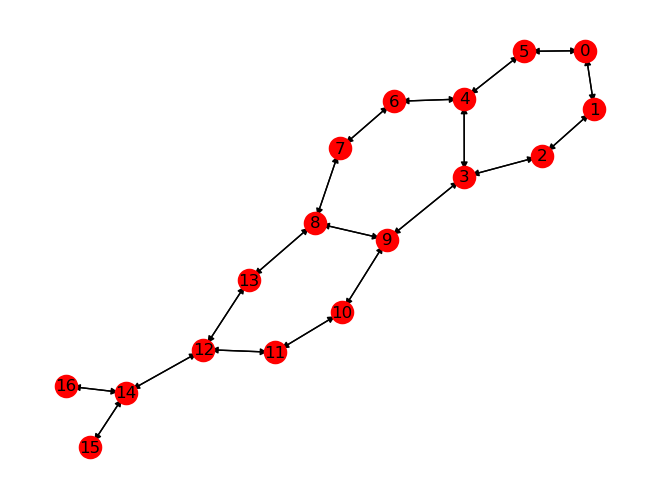

In [3]:
dataset = TUDataset('data', name='MUTAG')
gr.draw_graph(dataset[0])


In [286]:
d1 = dataset[1]
d2 = dataset[0]


In [287]:
def get_nl_number(input_graph):
    d = gr.get_neighbors(input_graph)
    names = []
    for k, v in d.items():
        neighb = [len(d[vv]) for vv in v]
        neighb.sort()
        name = [len(v)] + neighb
        names.append([sum(name) + 1])
    diff = len(input_graph.x) - len(names)
    print(diff)
    for i in range(diff):
        names.append([1])
    names.append([0, 0])
    return names


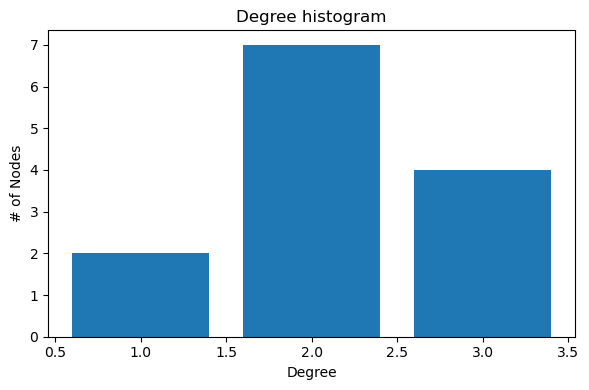

Degree sequence:  [2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 1, 1]
Degree histogram:  [0, 2, 7, 4]


In [288]:

degrees = gr.get_distrib(d1)
max_degree = max(degrees) + 1
h = []
for v in range(max_degree):
    h.append(degrees.count(v))
gr.plot_distr_plot(d1)
print("Degree sequence: ", degrees)
print("Degree histogram: ", h)

In [289]:

# calculate histograms
a1, a2, max_max = gr.calc_distrib(d1, d2)
# add empty nodes if needed
diff = sum(a2) - sum(a1) 
if diff > 0:
    a1[0] = diff
    coragraph = to_networkx(d1)
    while diff > 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff - 1
    d1_filled = from_networkx(coragraph)
    d1_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 1')
elif diff < 0: 
    a2[0] = abs(diff)
    coragraph = to_networkx(d2)
    while diff < 0:
        coragraph.add_node(max(list(coragraph.nodes))+1)
        diff = diff + 1
    d2_filled = from_networkx(coragraph)
    d2_filled.x = torch.ones(len(list(coragraph.nodes)), 1)
    print('Change 2')
# cost_matrix = gr_path.get_cost_matrix(max_max)

dist_1, dist_2, M, wass = gr.TMD_original(d1, d2, 1, L=2)
path, d = ot.emd(dist_1, dist_2, M, log=True) 

Change 1


In [290]:
d1 = d1_filled

C:\Users\ekima\anaconda3\envs\graphs\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


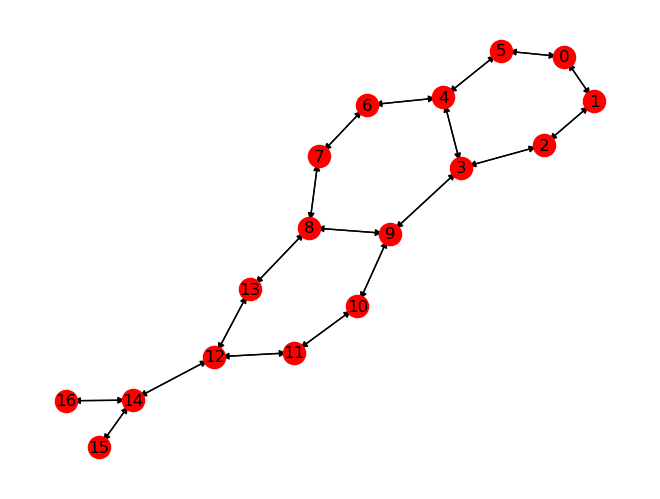

In [291]:
gr.draw_graph(d2)

In [377]:
G3 = to_networkx(d1)
G3 = G3.to_undirected()

G4 = to_networkx(d2)
G4 = G4.to_undirected()

G34 = to_networkx(d1)
G34 = G34.to_undirected()


# for i in G4.nodes():
#     d[i] = get_new_node(i, path)
# align nodes in two graphs     
# G4 = nx.relabel_nodes(G4, d)

for i in nx.optimize_edit_paths(G4, G3, timeout=0.005):
    print("Nodes: ", i[0])
    print("Edges: ", i[1])
    print("Cost: ", i[2])
    
    print("="*10)

Nodes:  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16)]
Edges:  [((0, 1), (0, 1)), ((1, 2), (1, 2)), ((2, 3), (2, 3)), ((3, 4), (3, 4)), ((0, 5), None), ((4, 5), (4, 5)), ((4, 6), None), (None, (5, 6)), ((6, 7), (6, 7)), (None, (2, 7)), ((7, 8), (7, 8)), ((3, 9), None), ((8, 9), (8, 9)), (None, (0, 9)), ((9, 10), None), (None, (8, 10)), ((10, 11), (10, 11)), ((11, 12), None), (None, (10, 12)), ((8, 13), None), ((12, 13), None), ((12, 14), None), ((14, 15), None), ((14, 16), None)]
Cost:  15.0


In [378]:
G34.edges(data=True)

EdgeDataView([(0, 1, {}), (0, 9, {}), (1, 2, {}), (2, 3, {}), (2, 7, {}), (3, 4, {}), (4, 5, {}), (5, 6, {}), (6, 7, {}), (7, 8, {}), (8, 9, {}), (8, 10, {}), (10, 11, {}), (10, 12, {})])

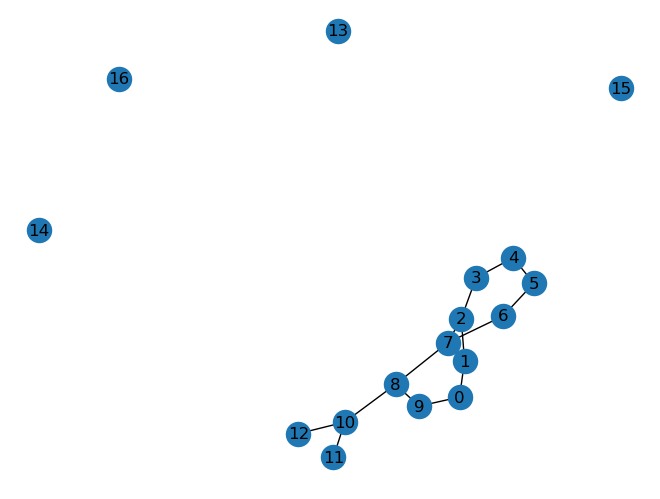

add  0 5


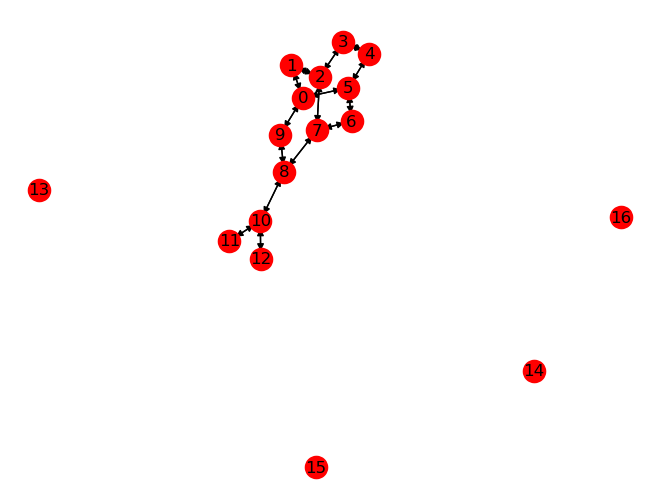

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  46.0
Distance to the second graph, level = 4:  84.0
add  4 6


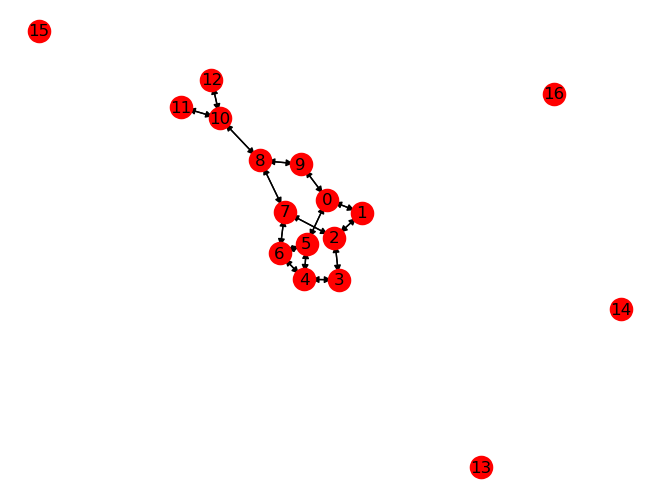

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  24.0
Distance to the second graph, level = 3:  40.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  98.0
Distance to the second graph, level = 4:  130.0
remove  5 6


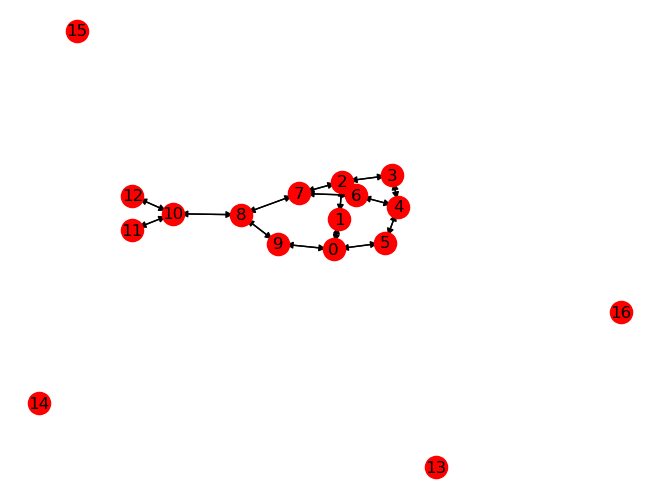

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  32.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  46.0
Distance to the second graph, level = 4:  100.0
remove  2 7


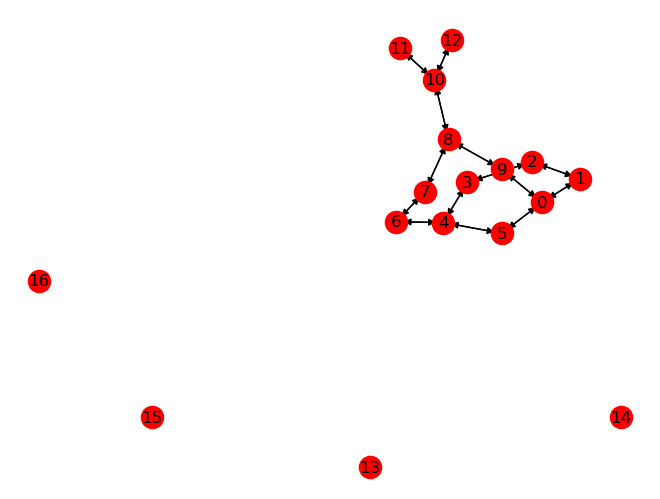

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  8.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  32.0
Distance to the second graph, level = 4:  106.0
add  3 9


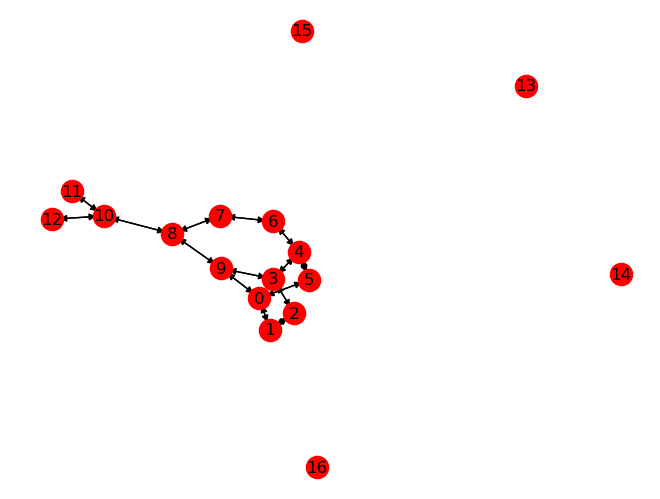

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  48.0
Distance to the second graph, level = 4:  80.0
remove  0 9


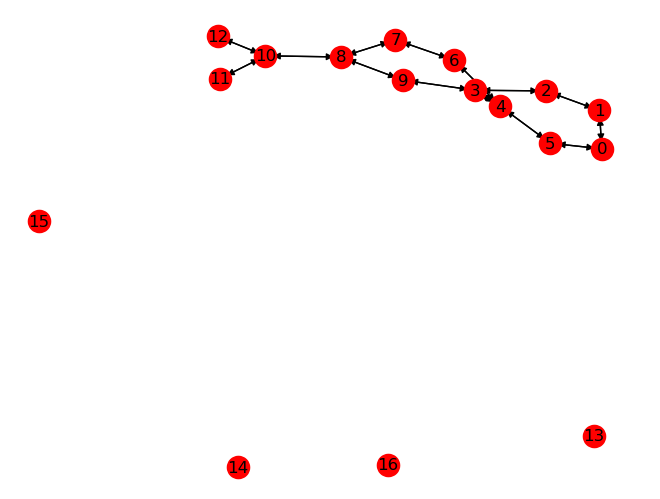

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  4.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  18.0
Distance to the second graph, level = 4:  104.0
add  9 10


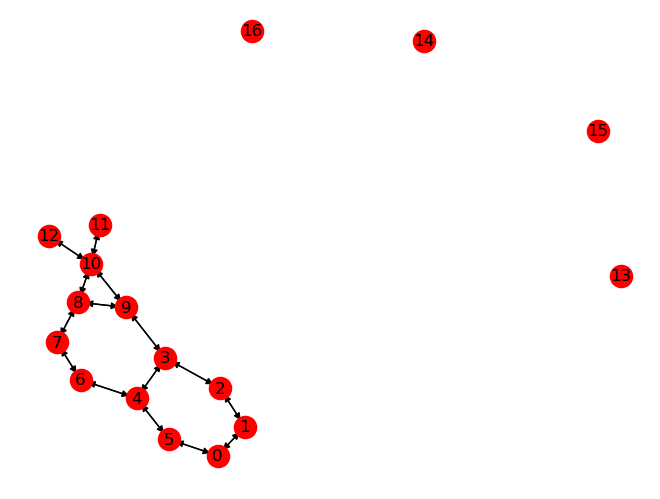

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  14.0
Distance to the second graph, level = 3:  40.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  58.0
Distance to the second graph, level = 4:  120.0
remove  8 10


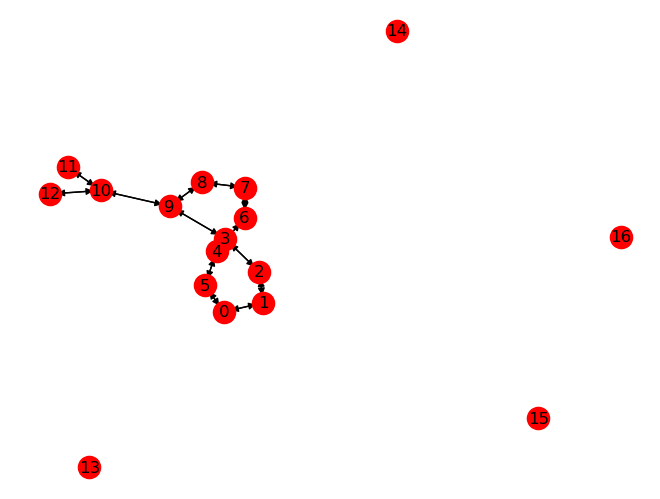

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  0.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  0.0
Distance to the second graph, level = 4:  102.0
add  11 12


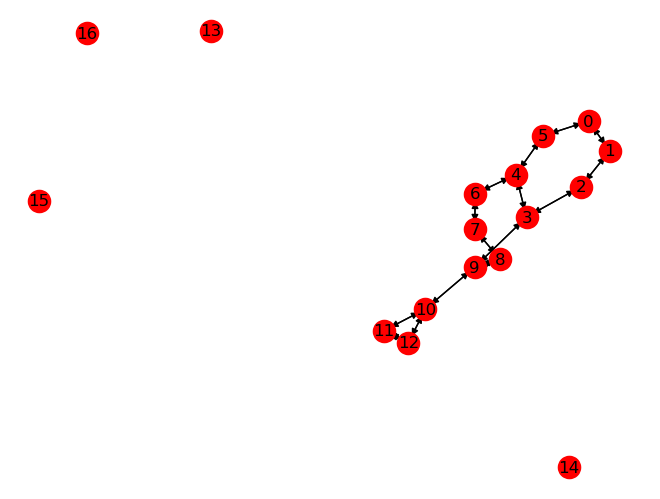

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  8.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  28.0
Distance to the second graph, level = 4:  74.0
remove  10 12


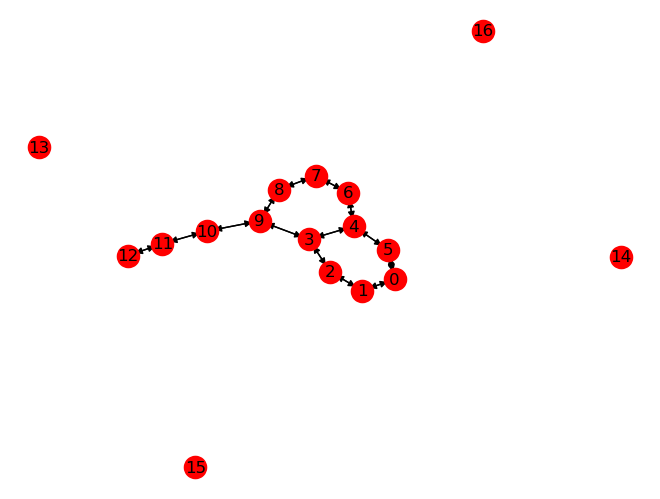

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  8.0
Distance to the second graph, level = 3:  38.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  24.0
Distance to the second graph, level = 4:  110.0
add  8 13


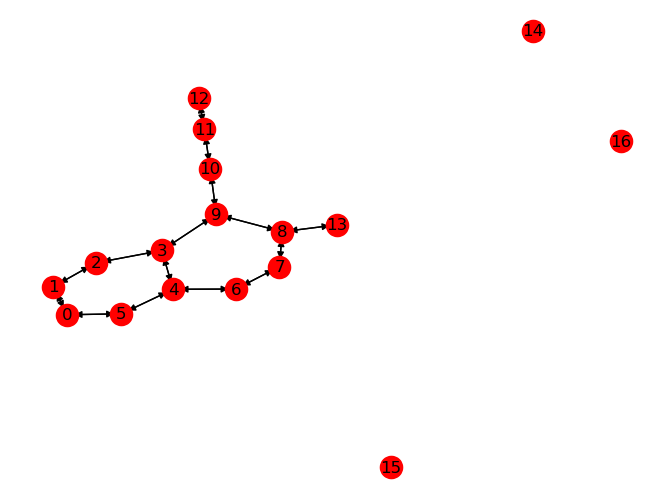

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  8.0
Distance to the second graph, level = 3:  30.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  22.0
Distance to the second graph, level = 4:  86.0
add  12 13


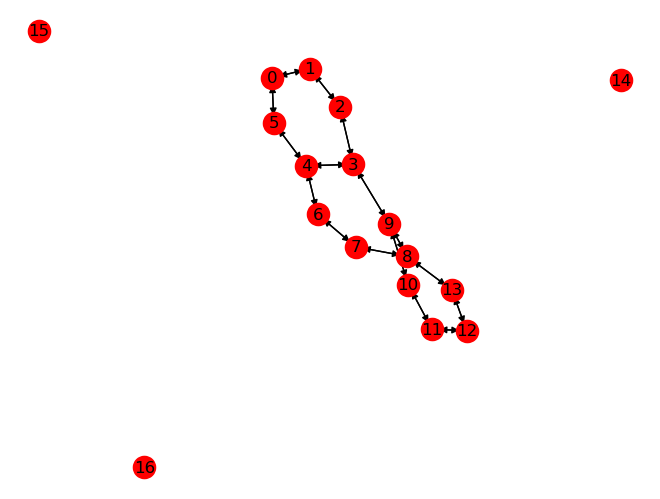

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  14.0
Distance to the second graph, level = 3:  22.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  44.0
Distance to the second graph, level = 4:  60.0
add  12 14


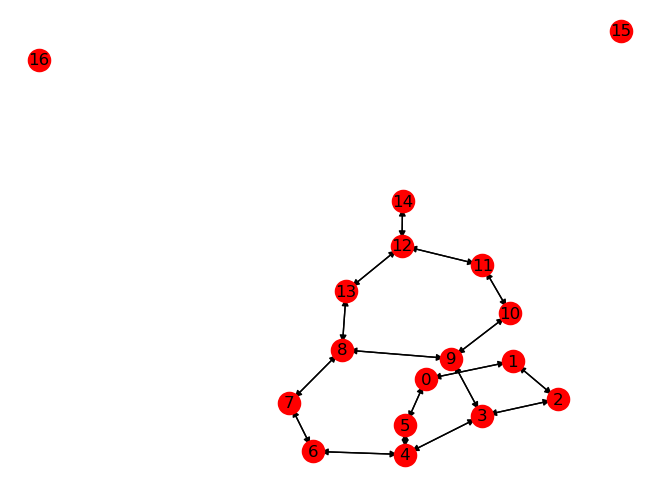

Distance between original graphs:  10.0
Distance to the first graph:  6.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  22.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  64.0
Distance to the second graph, level = 4:  38.0
add  14 15


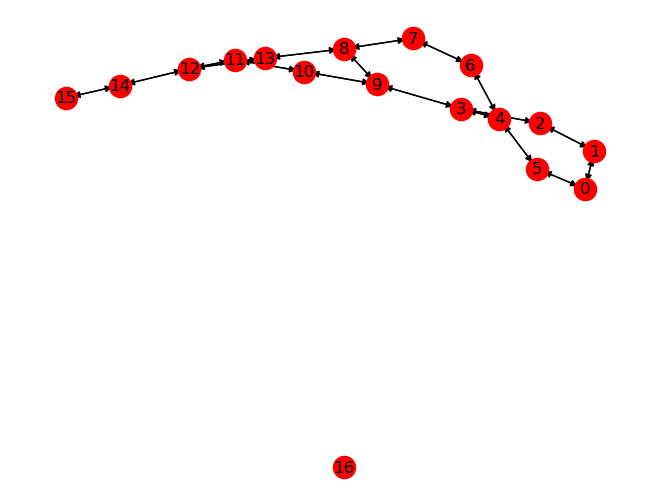

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  8.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  80.0
Distance to the second graph, level = 4:  22.0
add  14 16


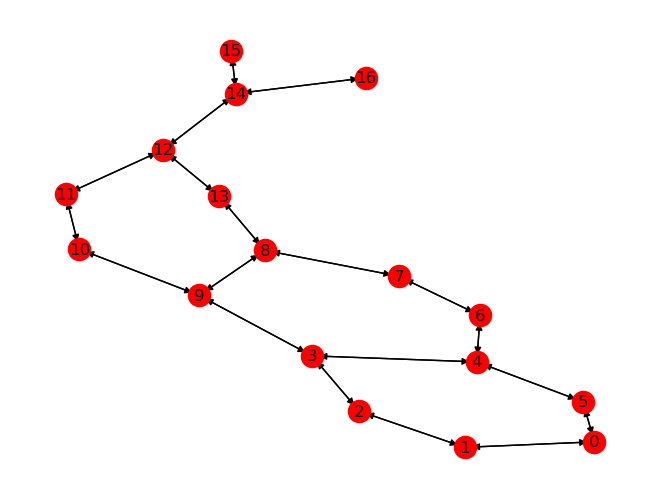

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  0.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  36.0
Distance to the second graph, level = 3:  0.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  102.0
Distance to the second graph, level = 4:  0.0


In [379]:
node_al = i[0]
edge_al = i[1]
nx.draw(G34,  with_labels=True)
#     fig.tight_layout()
plt.show()
follow_edit_path(G34, node_al, edge_al, d1, d2)

In [463]:
def return_eq(node1, node2):
    print(node1['degree'], node2['degree'])
    return node1['degree']==node2['degree']

def get_new_node(left_index, path):
    return int(np.where(path[left_index] == 1)[0])

In [ ]:

# def get_remove_edge_degree_cost_matrix(n):
#     m = np.zeros((n,n))
#     for i in range(n):
#         for j in range(n):
#             m[i][j] = i + j + 2
#     return m 


In [503]:

def get_add_edge_degree_cost_matrix(n):
    m = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            m[i][j] = i + j 
    return m 


In [295]:
# d1_degrees = gr.get_distrib(d1_filled)
# d2_degrees = gr.get_distrib(d2)

# d1_degrees_dict = dict(zip(range(19), d1_degrees))
# d2_degrees_dict = dict(zip(range(19), d2_degrees))

# nx.set_node_attributes(G3, d1_degrees_dict, "degree")
# nx.set_node_attributes(G4, d2_degrees_dict, "degree")

In [540]:
def set_node_degrees(G, d):
    d1_degrees = get_nl_number(d)
    d1_degrees_dict = dict(zip(range(len(d1_degrees) + 1), d1_degrees))
    nx.set_node_attributes(G, d1_degrees_dict, "degree")
    return G

In [541]:
# def set_node_degrees(G, d):
#     d1_degrees = gr.get_distrib(d)
#     d1_degrees_dict = dict(zip(range(len(d1_degrees) + 1), d1_degrees))
#     nx.set_node_attributes(G, d1_degrees_dict, "degree")
#     return G

In [542]:
def set_edge_degrees(G):
    edges = G.edges()
    us = []
    vs = []
    for u, v in edges:
        us.append(G.nodes[u]['degree'])
        vs.append(G.nodes[v]['degree'])

    degrees_1 = dict(zip(edges, us))
    degrees_2 = dict(zip(edges, vs))

    nx.set_edge_attributes(G, degrees_1, "degree1")
    nx.set_edge_attributes(G, degrees_2, "degree2")
    return G

In [556]:
G3 = to_networkx(d1)
G3 = G3.to_undirected()

G4 = to_networkx(d2)
G4 = G4.to_undirected()

G34 = to_networkx(d2)
G34 = G34.to_undirected()

# d = {}
# for i in G4.nodes():
#     d[i] = get_new_node(i, path)
# align nodes in two graphs     
# G4 = nx.relabel_nodes(G4, d)

G3 = set_node_degrees(G3, d1)
G3 = set_edge_degrees(G3)

# G34 = set_node_degrees(G34, d1)
# G34 = set_edge_degrees(G34)

G4 = set_node_degrees(G4, d2)
G4 = set_edge_degrees(G4)

4
0


In [557]:
print(G4.nodes(data=True))
print(G4.edges(data=True))

[(0, {'degree': [7]}), (1, {'degree': [7]}), (2, {'degree': [8]}), (3, {'degree': [12]}), (4, {'degree': [11]}), (5, {'degree': [8]}), (6, {'degree': [8]}), (7, {'degree': [8]}), (8, {'degree': [11]}), (9, {'degree': [12]}), (10, {'degree': [8]}), (11, {'degree': [8]}), (12, {'degree': [11]}), (13, {'degree': [9]}), (14, {'degree': [9]}), (15, {'degree': [5]}), (16, {'degree': [5]})]
[(0, 1, {'degree1': [7], 'degree2': [7]}), (0, 5, {'degree1': [7], 'degree2': [8]}), (1, 2, {'degree1': [7], 'degree2': [8]}), (2, 3, {'degree1': [8], 'degree2': [12]}), (3, 4, {'degree1': [12], 'degree2': [11]}), (3, 9, {'degree1': [12], 'degree2': [12]}), (4, 5, {'degree1': [11], 'degree2': [8]}), (4, 6, {'degree1': [11], 'degree2': [8]}), (6, 7, {'degree1': [8], 'degree2': [8]}), (7, 8, {'degree1': [8], 'degree2': [11]}), (8, 9, {'degree1': [11], 'degree2': [12]}), (8, 13, {'degree1': [11], 'degree2': [9]}), (9, 10, {'degree1': [12], 'degree2': [8]}), (10, 11, {'degree1': [8], 'degree2': [8]}), (11, 12,

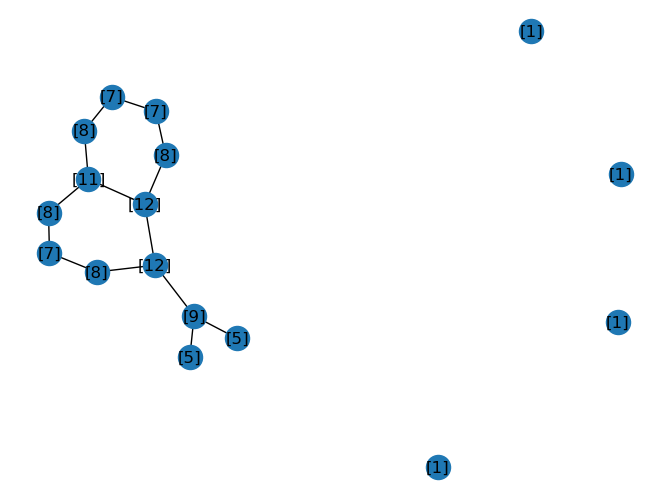

In [558]:
nx.draw(G3,  labels=nx.get_node_attributes(G3, 'degree'))

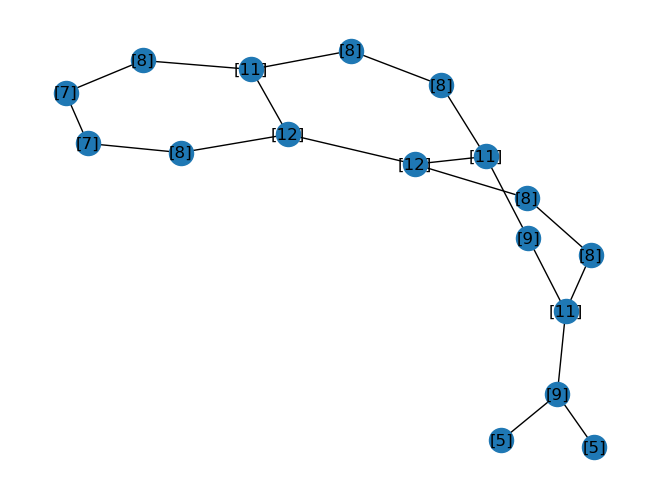

In [559]:
nx.draw(G4,  labels=nx.get_node_attributes(G4, 'degree'))

In [560]:
def node_ins_cost_degree(edge):
    degree1 = edge['degree1'][0]
    degree2 = edge['degree2'][0]
    print(edge)
    cost = get_add_edge_degree_cost_matrix(20)
    return cost[degree1][degree2]
    

In [561]:
for i in nx.optimize_edit_paths(G3, G4, timeout=0.1005, node_match=return_eq, edge_ins_cost=node_ins_cost_degree, edge_del_cost=node_ins_cost_degree):
    print("Nodes: ", i[0])
    print("Edges: ", i[1])
    print("Cost: ", i[2])
    
    print("="*10)

[7] [7]
[7] [7]
[7] [8]
[7] [12]
[7] [11]
[7] [8]
[7] [8]
[7] [8]
[7] [11]
[7] [12]
[7] [8]
[7] [8]
[7] [11]
[7] [9]
[7] [9]
[7] [5]
[7] [5]
[8] [7]
[8] [7]
[8] [8]
[8] [12]
[8] [11]
[8] [8]
[8] [8]
[8] [8]
[8] [11]
[8] [12]
[8] [8]
[8] [8]
[8] [11]
[8] [9]
[8] [9]
[8] [5]
[8] [5]
[11] [7]
[11] [7]
[11] [8]
[11] [12]
[11] [11]
[11] [8]
[11] [8]
[11] [8]
[11] [11]
[11] [12]
[11] [8]
[11] [8]
[11] [11]
[11] [9]
[11] [9]
[11] [5]
[11] [5]
[8] [7]
[8] [7]
[8] [8]
[8] [12]
[8] [11]
[8] [8]
[8] [8]
[8] [8]
[8] [11]
[8] [12]
[8] [8]
[8] [8]
[8] [11]
[8] [9]
[8] [9]
[8] [5]
[8] [5]
[7] [7]
[7] [7]
[7] [8]
[7] [12]
[7] [11]
[7] [8]
[7] [8]
[7] [8]
[7] [11]
[7] [12]
[7] [8]
[7] [8]
[7] [11]
[7] [9]
[7] [9]
[7] [5]
[7] [5]
[7] [7]
[7] [7]
[7] [8]
[7] [12]
[7] [11]
[7] [8]
[7] [8]
[7] [8]
[7] [11]
[7] [12]
[7] [8]
[7] [8]
[7] [11]
[7] [9]
[7] [9]
[7] [5]
[7] [5]
[8] [7]
[8] [7]
[8] [8]
[8] [12]
[8] [11]
[8] [8]
[8] [8]
[8] [8]
[8] [11]
[8] [12]
[8] [8]
[8] [8]
[8] [11]
[8] [9]
[8] [9]
[8] [5]
[8] 

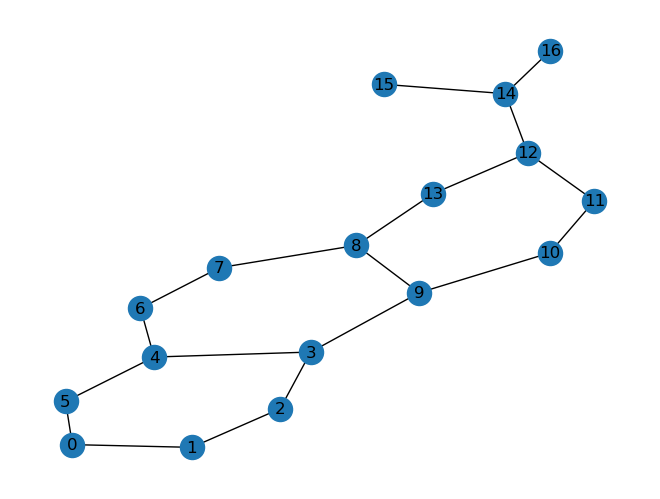

add  0 2


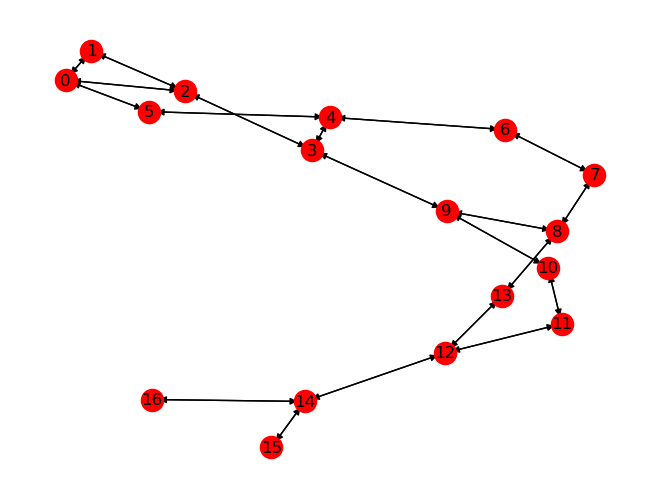

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  48.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  150.0
Distance to the second graph, level = 4:  48.0
add  2 4


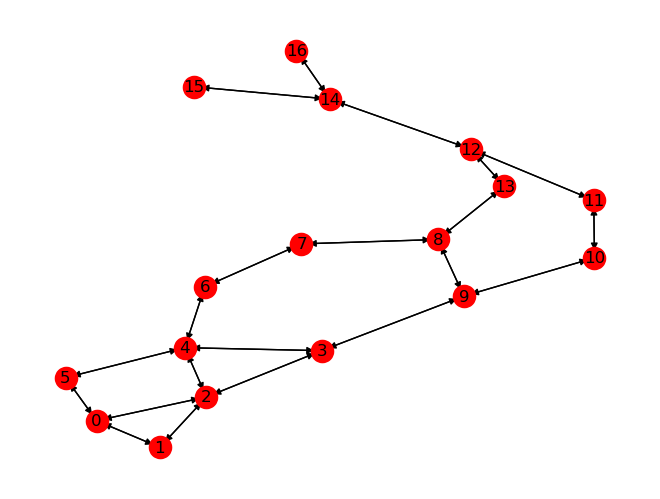

Distance between original graphs:  10.0
Distance to the first graph:  14.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  64.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  228.0
Distance to the second graph, level = 4:  126.0
remove  0 5


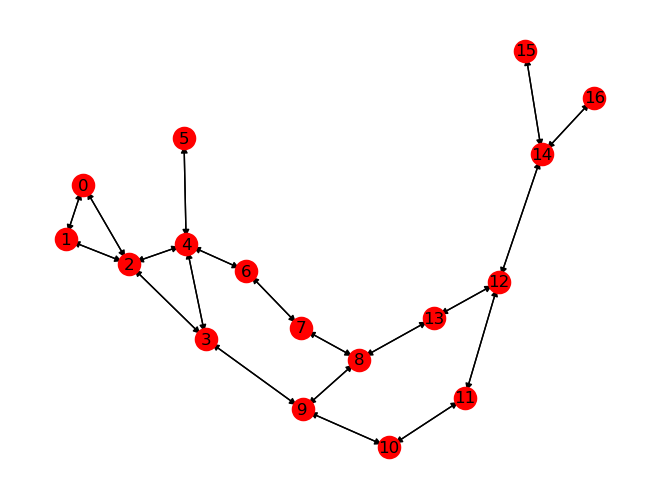

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  54.0
Distance to the second graph, level = 3:  24.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  186.0
Distance to the second graph, level = 4:  98.0
add  5 1


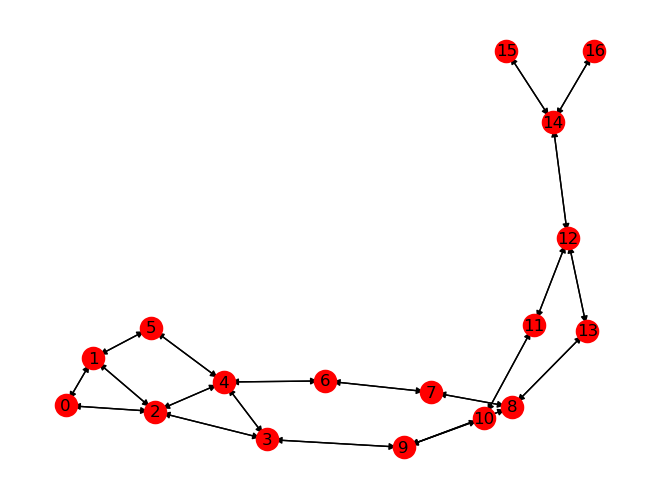

Distance between original graphs:  10.0
Distance to the first graph:  14.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  64.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  228.0
Distance to the second graph, level = 4:  126.0
remove  0 1


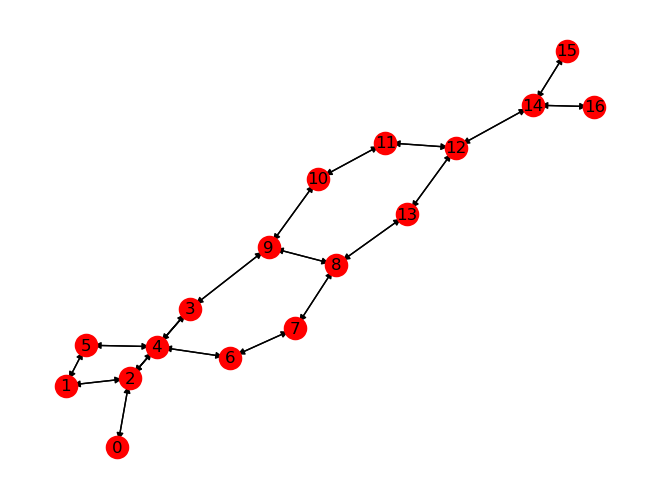

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  54.0
Distance to the second graph, level = 3:  24.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  186.0
Distance to the second graph, level = 4:  98.0
remove  1 2


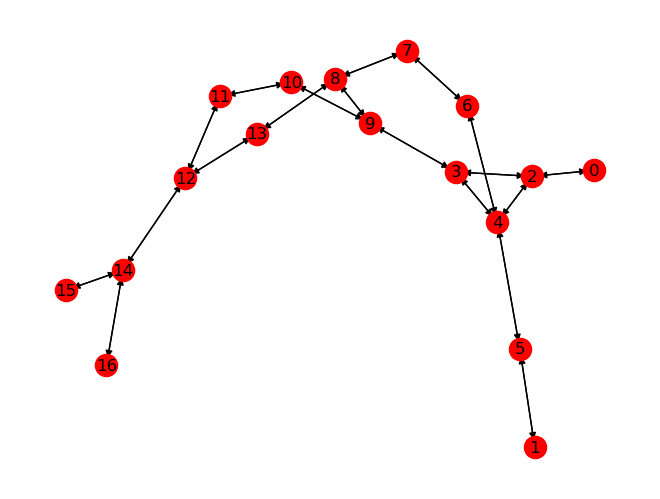

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  42.0
Distance to the second graph, level = 3:  20.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  138.0
Distance to the second graph, level = 4:  72.0
add  1 7


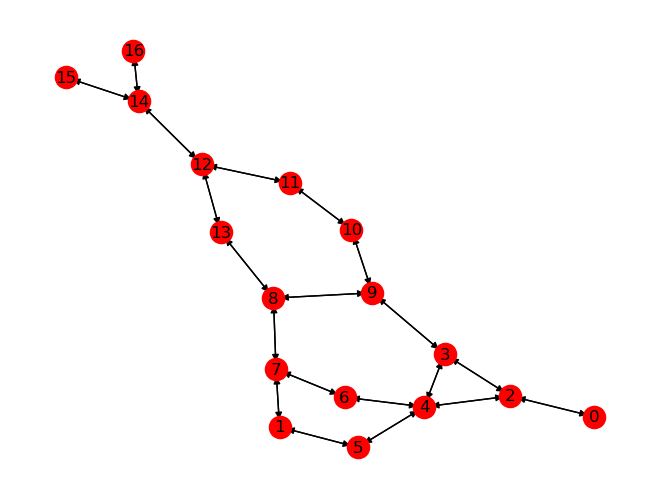

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  52.0
Distance to the second graph, level = 3:  22.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  174.0
Distance to the second graph, level = 4:  86.0
remove  4 6


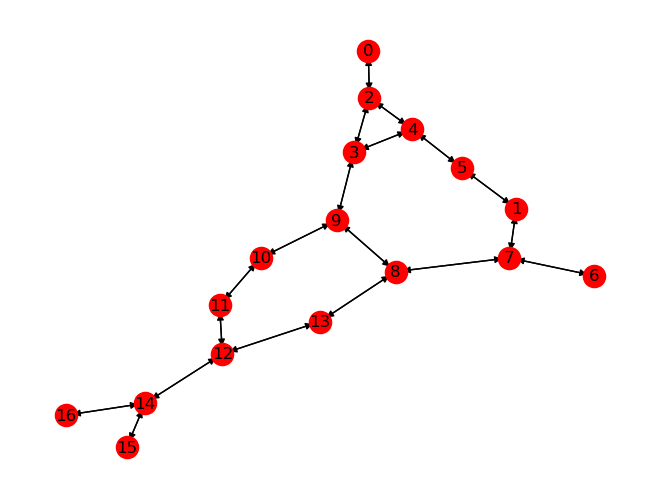

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  40.0
Distance to the second graph, level = 3:  16.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  124.0
Distance to the second graph, level = 4:  52.0
add  4 9


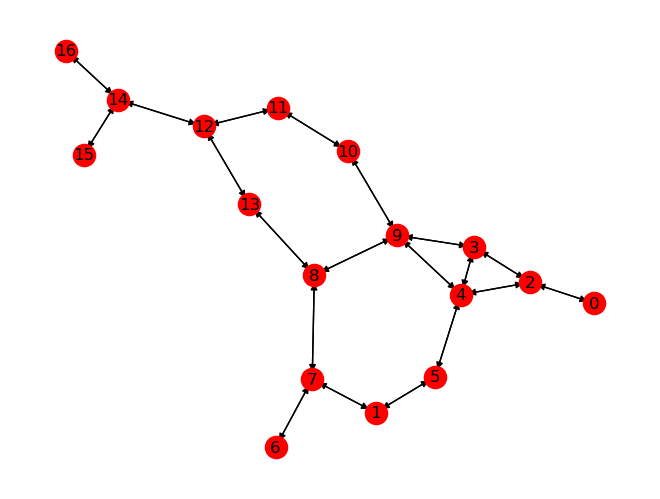

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  56.0
Distance to the second graph, level = 3:  32.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  204.0
Distance to the second graph, level = 4:  132.0
add  6 9


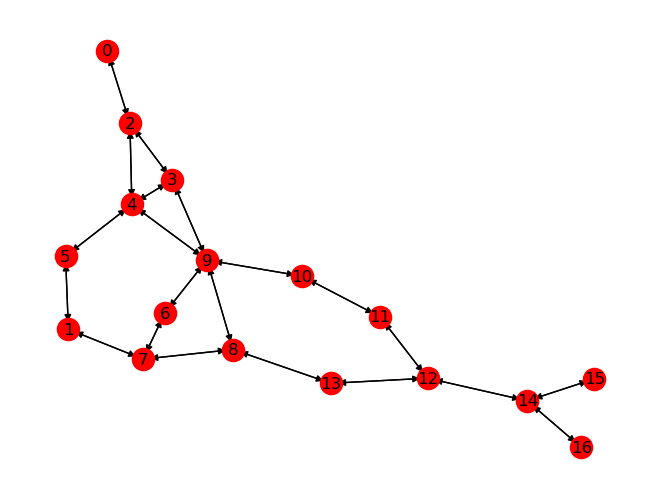

Distance between original graphs:  10.0
Distance to the first graph:  14.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  70.0
Distance to the second graph, level = 3:  40.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  268.0
Distance to the second graph, level = 4:  180.0
remove  2 3


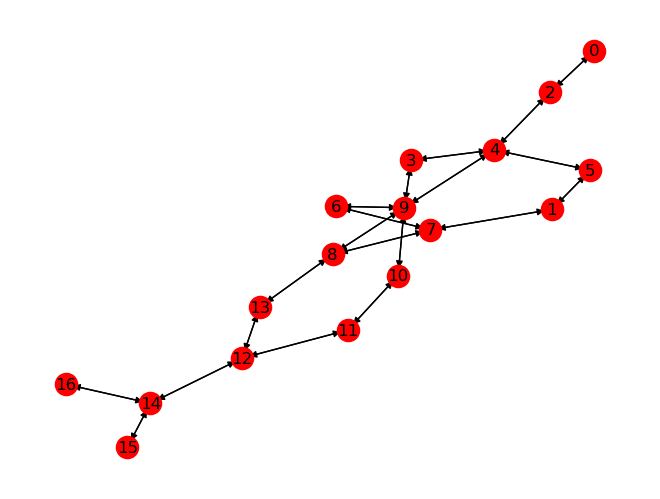

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  58.0
Distance to the second graph, level = 3:  30.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  210.0
Distance to the second graph, level = 4:  130.0
remove  3 4


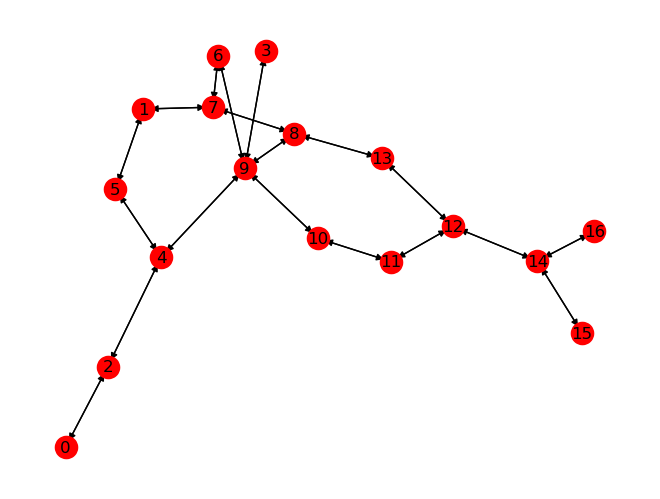

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  46.0
Distance to the second graph, level = 3:  24.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  154.0
Distance to the second graph, level = 4:  90.0
add  0 10


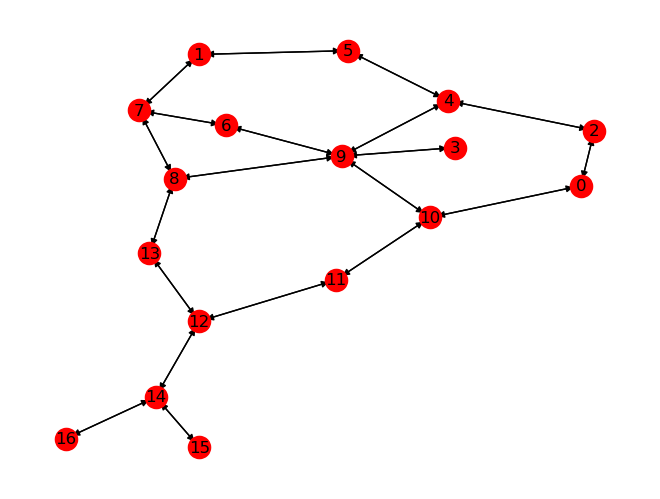

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  56.0
Distance to the second graph, level = 3:  26.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  194.0
Distance to the second graph, level = 4:  106.0
add  3 10


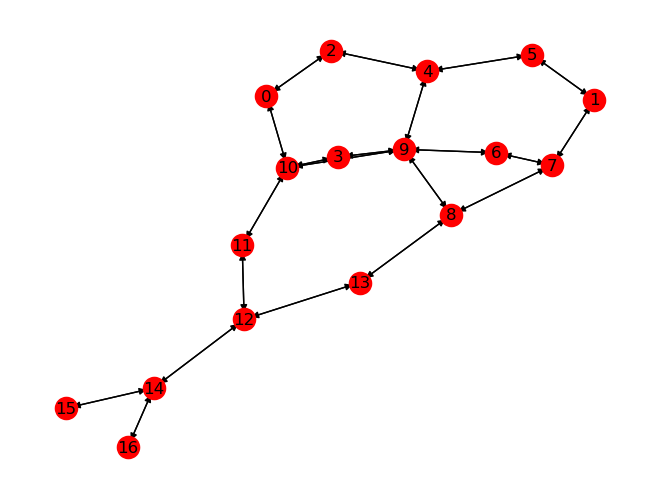

Distance between original graphs:  10.0
Distance to the first graph:  14.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  68.0
Distance to the second graph, level = 3:  32.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  250.0
Distance to the second graph, level = 4:  148.0
remove  9 10


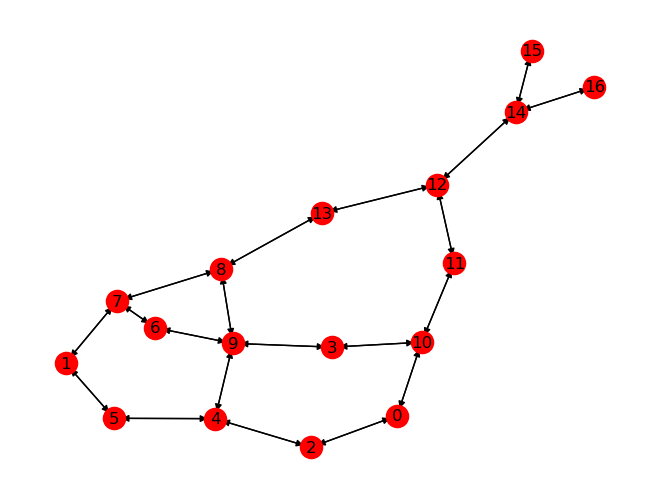

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  50.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  160.0
Distance to the second graph, level = 4:  58.0
add  3 13


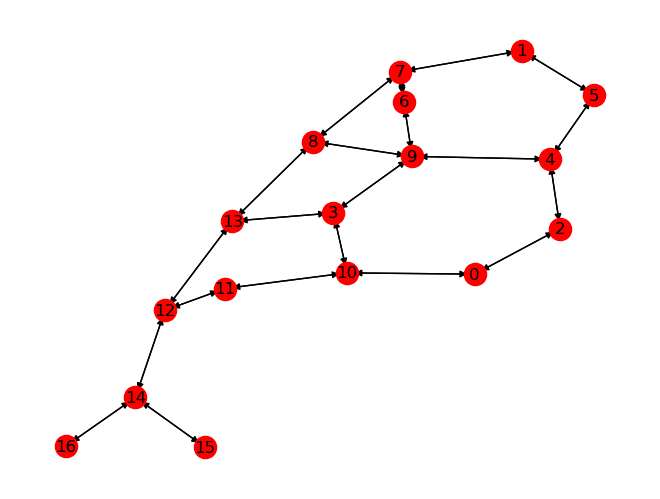

Distance between original graphs:  10.0
Distance to the first graph:  14.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  62.0
Distance to the second graph, level = 3:  26.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  216.0
Distance to the second graph, level = 4:  114.0
remove  7 8


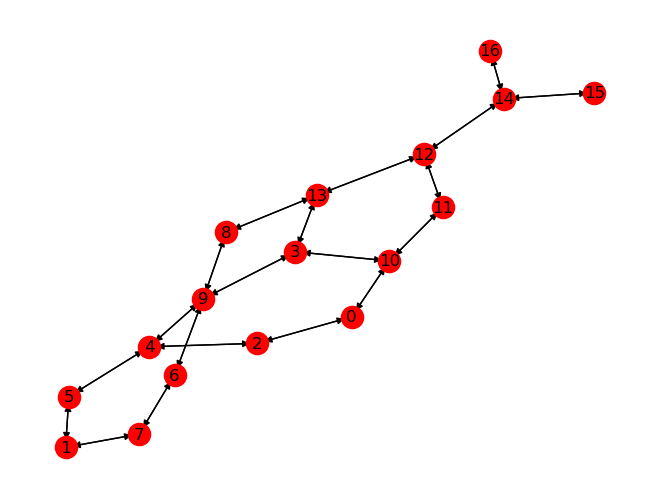

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  50.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  164.0
Distance to the second graph, level = 4:  62.0
remove  8 9


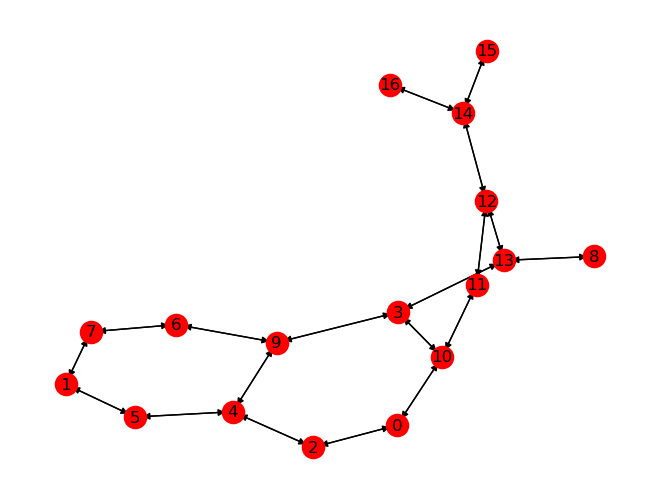

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  38.0
Distance to the second graph, level = 3:  8.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  114.0
Distance to the second graph, level = 4:  30.0
remove  10 11


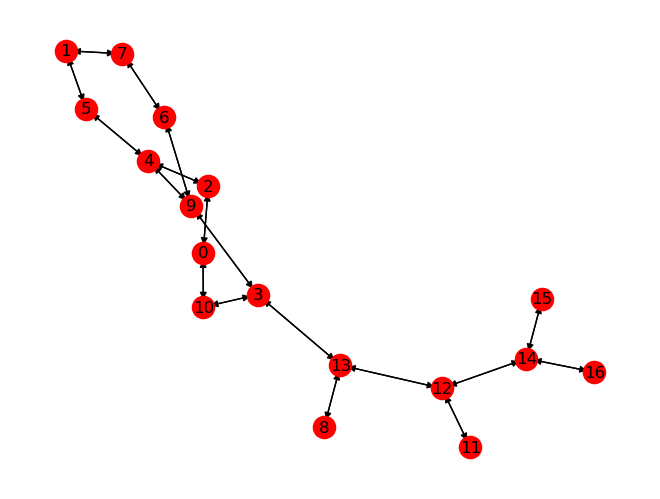

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  76.0
Distance to the second graph, level = 4:  42.0
remove  11 12


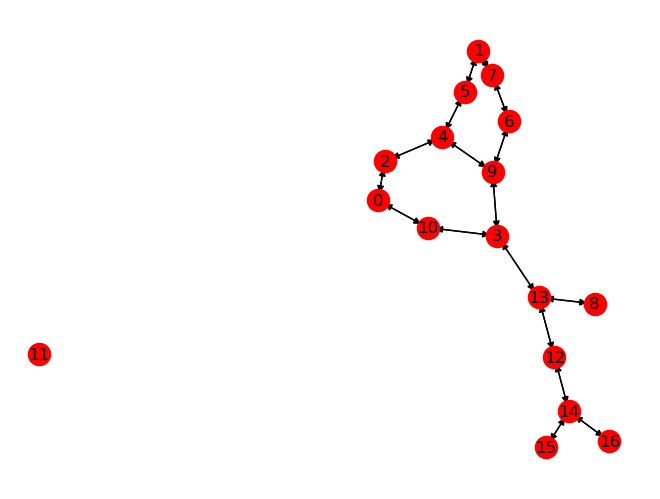

Distance between original graphs:  10.0
Distance to the first graph:  6.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  20.0
Distance to the second graph, level = 3:  16.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  50.0
Distance to the second graph, level = 4:  52.0
remove  12 14


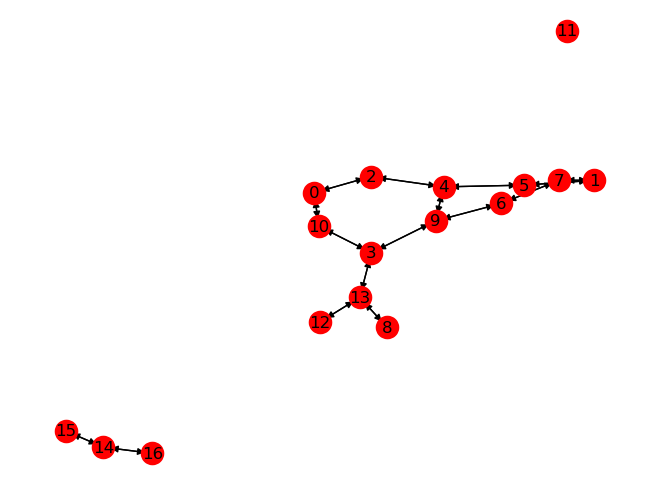

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  10.0
Distance to the second graph, level = 3:  26.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  18.0
Distance to the second graph, level = 4:  84.0
remove  14 15


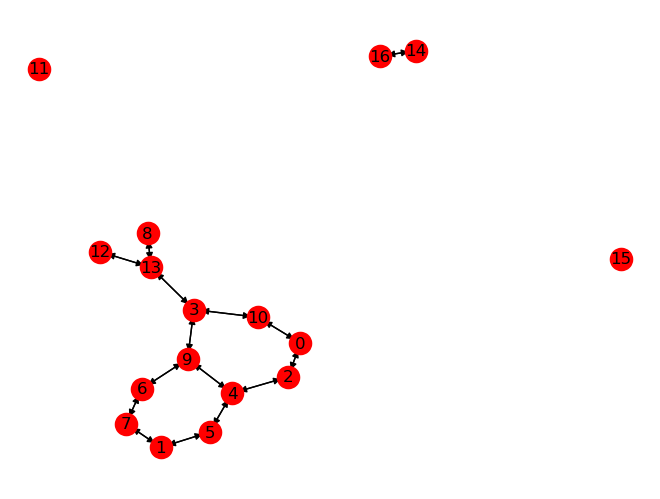

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  4.0
Distance to the second graph, level = 3:  32.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  6.0
Distance to the second graph, level = 4:  96.0
remove  14 16


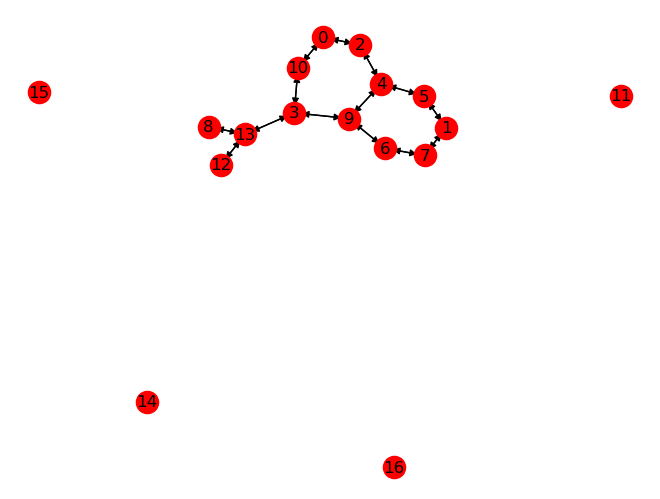

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  0.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  0.0
Distance to the second graph, level = 4:  102.0


In [562]:
#both add and delete 
node_al = i[0]
edge_al = i[1]
nx.draw(G34,  with_labels=True)
#     fig.tight_layout()
plt.show()
follow_edit_path(G34, node_al, edge_al, d1, d2)

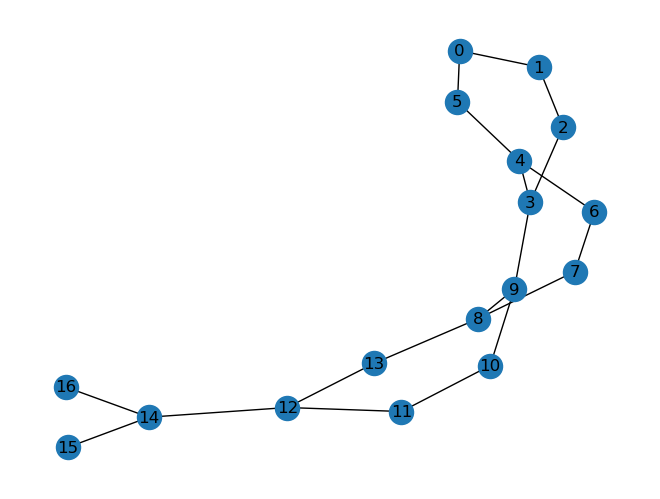

remove  0 5


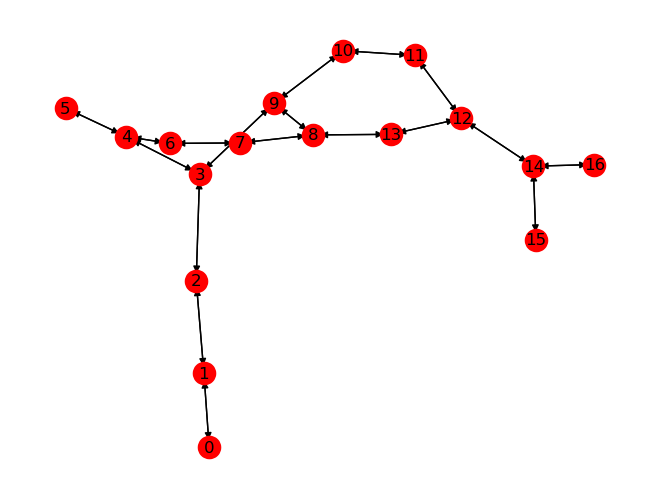

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  8.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  78.0
Distance to the second graph, level = 4:  26.0
add  5 6


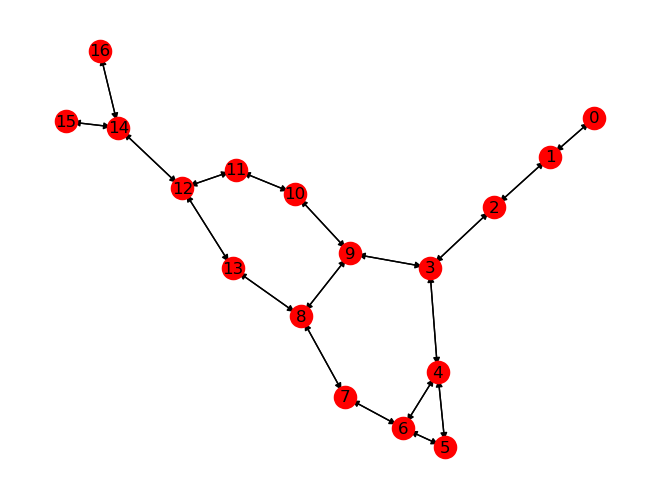

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  38.0
Distance to the second graph, level = 3:  10.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  114.0
Distance to the second graph, level = 4:  38.0
remove  4 6


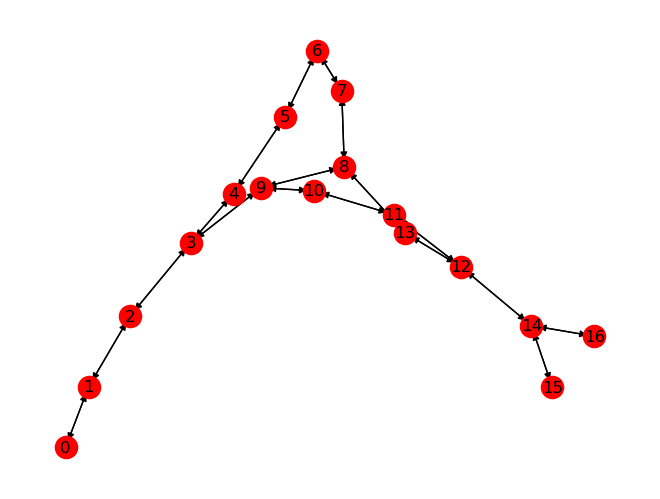

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  10.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  76.0
Distance to the second graph, level = 4:  36.0
add  2 7


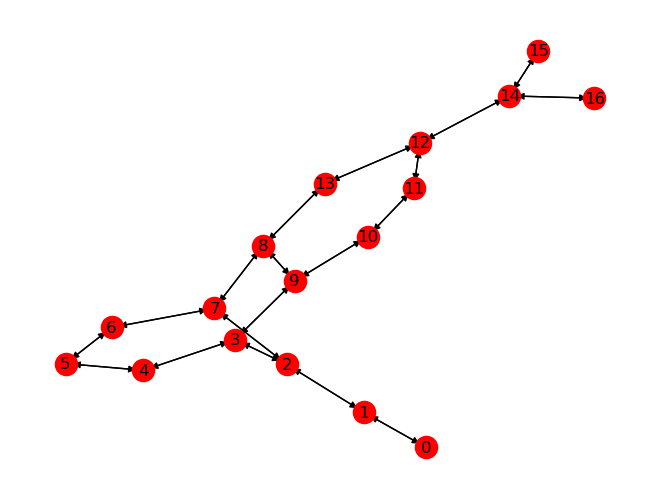

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  38.0
Distance to the second graph, level = 3:  10.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  116.0
Distance to the second graph, level = 4:  38.0
add  0 9


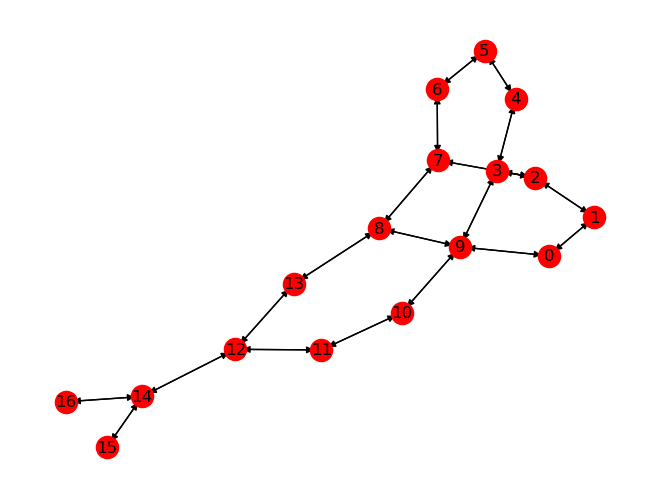

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  50.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  164.0
Distance to the second graph, level = 4:  62.0
remove  3 9


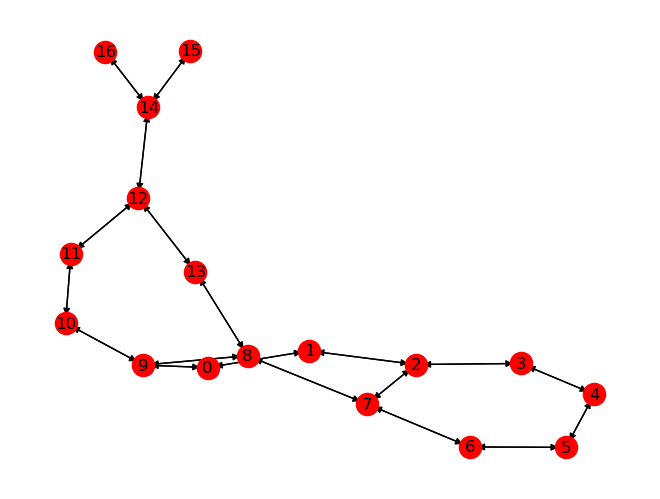

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  0.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  36.0
Distance to the second graph, level = 3:  0.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  102.0
Distance to the second graph, level = 4:  4.0
add  8 10


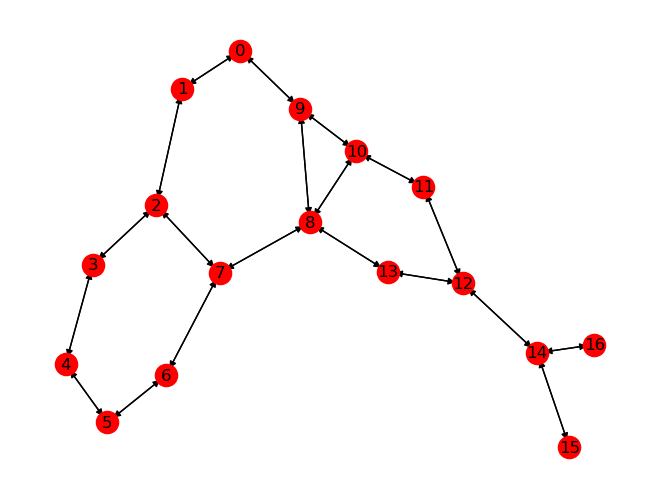

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  50.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  166.0
Distance to the second graph, level = 4:  64.0
remove  9 10


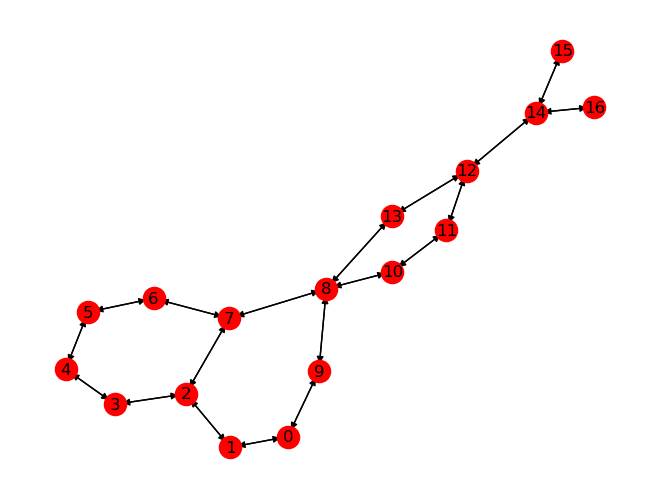

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  40.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  122.0
Distance to the second graph, level = 4:  48.0
add  10 12


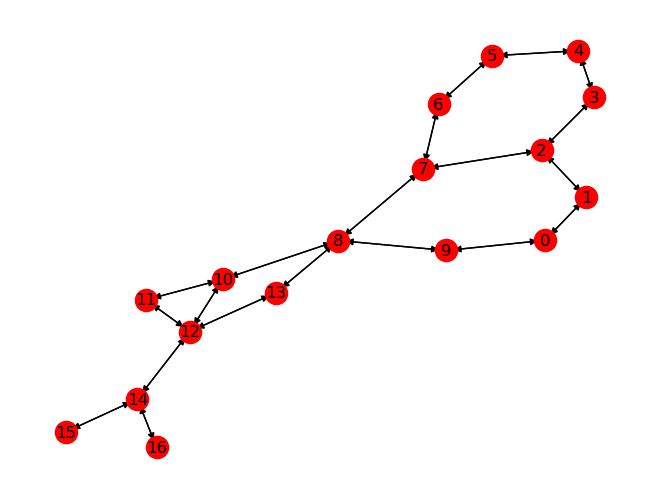

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  52.0
Distance to the second graph, level = 3:  18.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  176.0
Distance to the second graph, level = 4:  84.0
remove  11 12


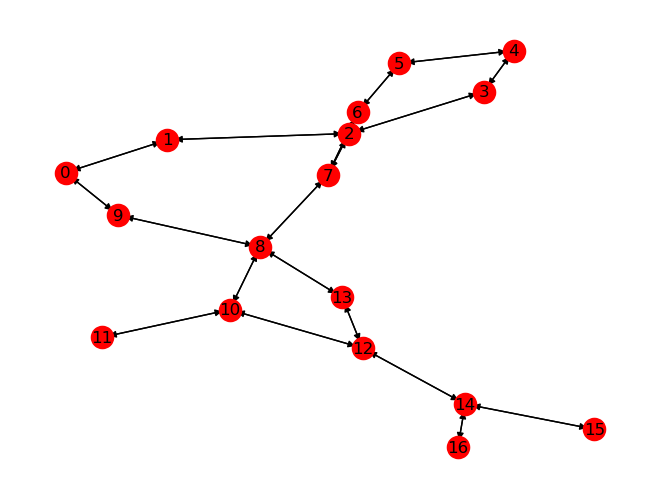

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  40.0
Distance to the second graph, level = 3:  14.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  126.0
Distance to the second graph, level = 4:  58.0
remove  8 13


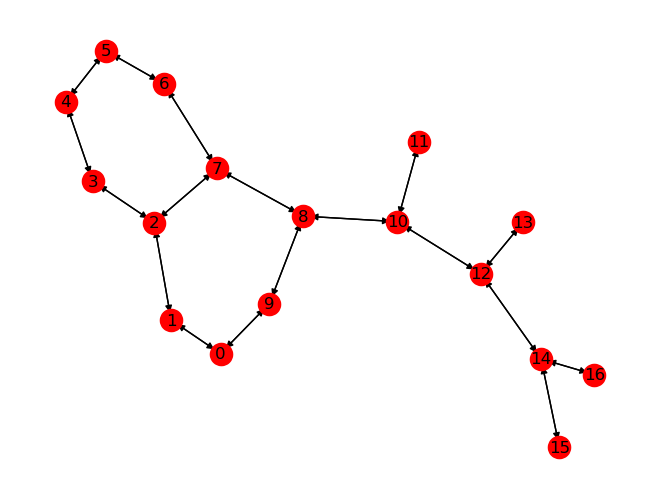

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  76.0
Distance to the second graph, level = 4:  42.0
remove  12 13


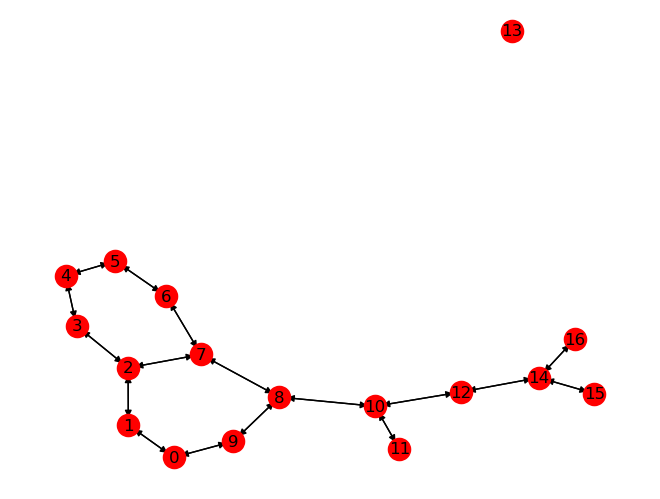

Distance between original graphs:  10.0
Distance to the first graph:  6.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  20.0
Distance to the second graph, level = 3:  16.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  50.0
Distance to the second graph, level = 4:  52.0
remove  12 14


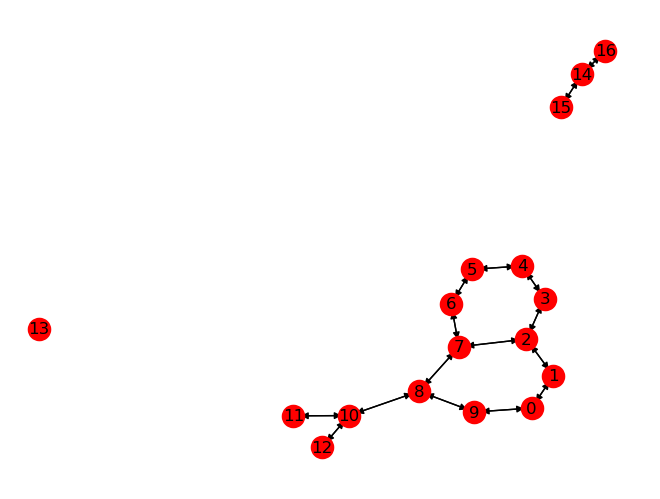

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  10.0
Distance to the second graph, level = 3:  26.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  18.0
Distance to the second graph, level = 4:  84.0
remove  14 15


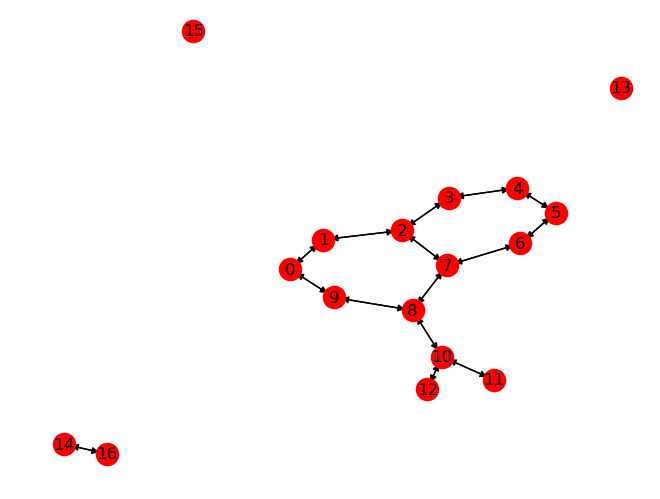

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  4.0
Distance to the second graph, level = 3:  32.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  6.0
Distance to the second graph, level = 4:  96.0
remove  14 16


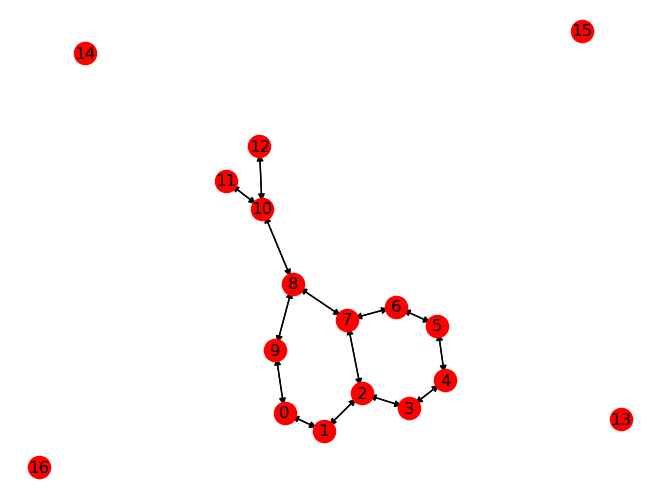

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  0.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  0.0
Distance to the second graph, level = 4:  102.0


In [510]:
node_al = i[0]
edge_al = i[1]
nx.draw(G34,  with_labels=True)
#     fig.tight_layout()
plt.show()
follow_edit_path(G34, node_al, edge_al, d1, d2)

In [489]:
G3 = to_networkx(d1)
G3 = G3.to_undirected()

G4 = to_networkx(d2)
G4 = G4.to_undirected()

G34 = to_networkx(d1)
G34 = G34.to_undirected()

# d = {}
# for i in G4.nodes():
#     d[i] = get_new_node(i, path)
# align nodes in two graphs     
# G4 = nx.relabel_nodes(G4, d)

G3 = set_node_degrees(G3, d1)
G3 = set_edge_degrees(G3)

# G34 = set_node_degrees(G34, d1)
# G34 = set_edge_degrees(G34)

G4 = set_node_degrees(G4, d2)
G4 = set_edge_degrees(G4)

<AxesSubplot: >

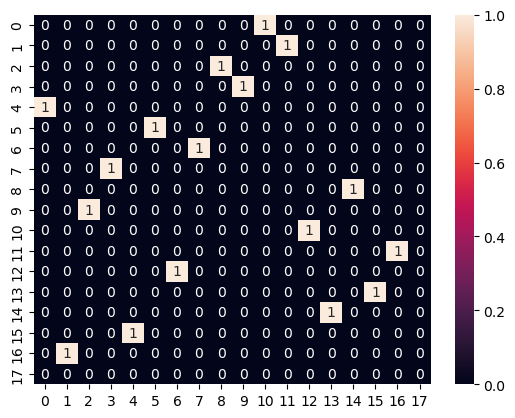

In [490]:
l = 2
dist_1, dist_2, M, wass = gr.TMD_original(d1_filled, d2, 1, L=l)
path, d = ot.emd(dist_1, dist_2, M, log=True) 

sns.heatmap(path, annot=True)

# # distance with no alignment
# for i in nx.optimize_edit_paths(G3, G4, timeout=0.05): #, node_match=return_eq):
#     print(i)

In [491]:
# for i in G4.nodes():
#     d[i] = get_new_node(i, path)
# align nodes in two graphs     
# G4 = nx.relabel_nodes(G4, d)
# G34 = nx.relabel_nodes(G34, d)

In [492]:
# distance with no alignment
for i in nx.optimize_edit_paths(G4, G3, timeout=1,  node_match=return_eq):
    print(i)

2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
3 2
3 2
3 3
3 2
3 2
3 2
3 2
3 3
3 3
3 2
3 3
3 1
3 1
3 0
3 0
3 0
3 0
3 2
3 2
3 3
3 2
3 2
3 2
3 2
3 3
3 3
3 2
3 3
3 1
3 1
3 0
3 0
3 0
3 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
3 2
3 2
3 3
3 2
3 2
3 2
3 2
3 3
3 3
3 2
3 3
3 1
3 1
3 0
3 0
3 0
3 0
3 2
3 2
3 3
3 2
3 2
3 2
3 2
3 3
3 3
3 2
3 3
3 1
3 1
3 0
3 0
3 0
3 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
3 2
3 2
3 3
3 2
3 2
3 2
3 2
3 3
3 3
3 2
3 3
3 1
3 1
3 0
3 0
3 0
3 0
2 2
2 2
2 3
2 2
2 2
2 2
2 2
2 3
2 3
2 2
2 3
2 1
2 1
2 0
2 0
2 0
2 0
3 2
3 2
3 3
3 2
3 2
3 2
3 2
3 3
3 3
3 2
3 3
3 1


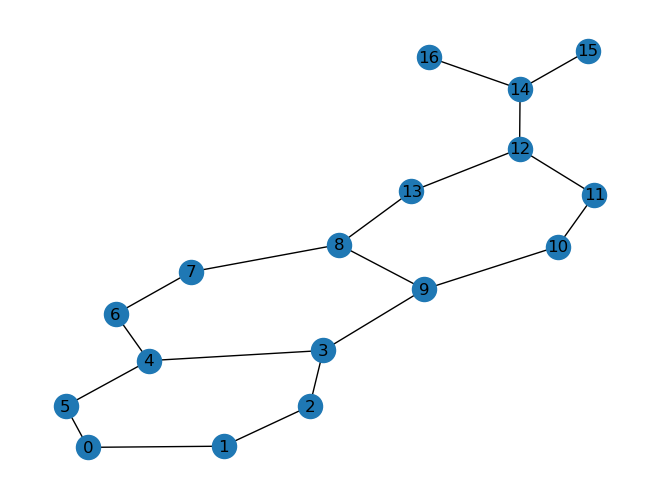

In [493]:

nx.draw(G4,  with_labels=True)

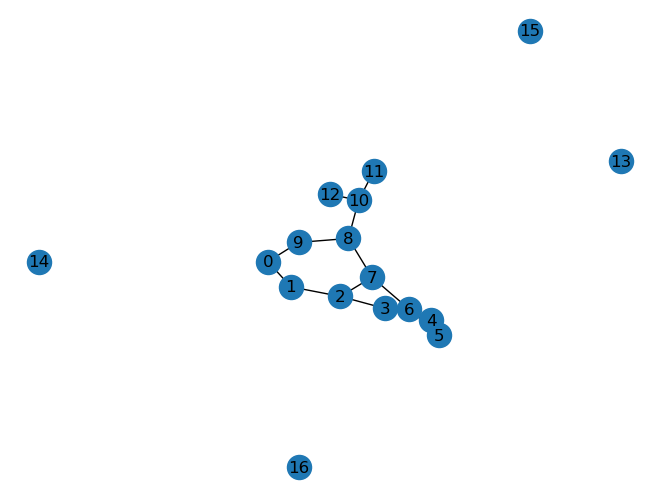

In [494]:

nx.draw(G3,  with_labels=True)

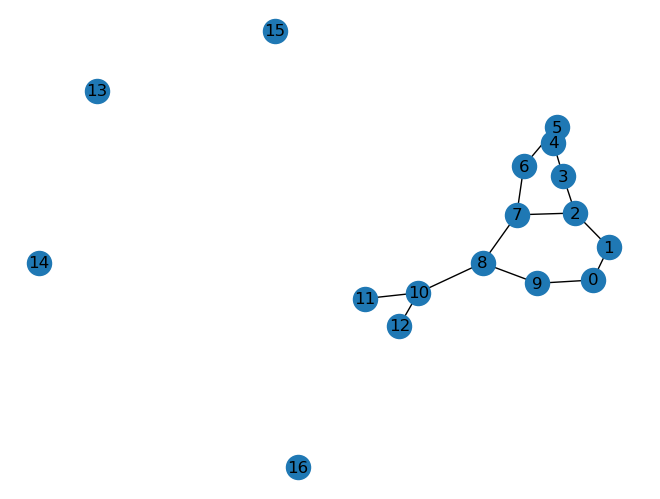

add  1 3


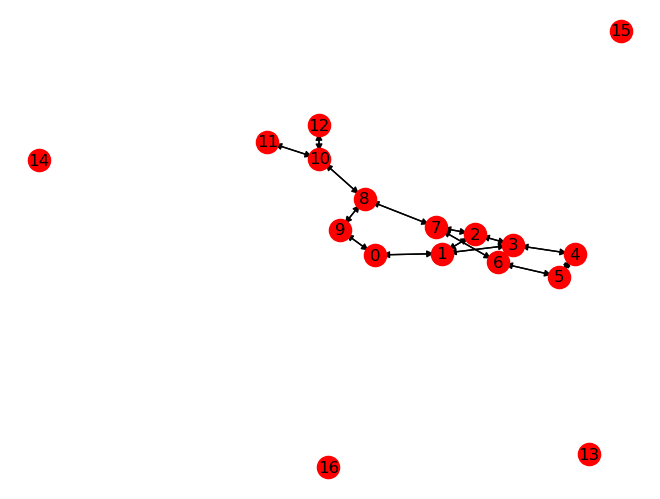

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  32.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  50.0
Distance to the second graph, level = 4:  96.0
remove  1 2


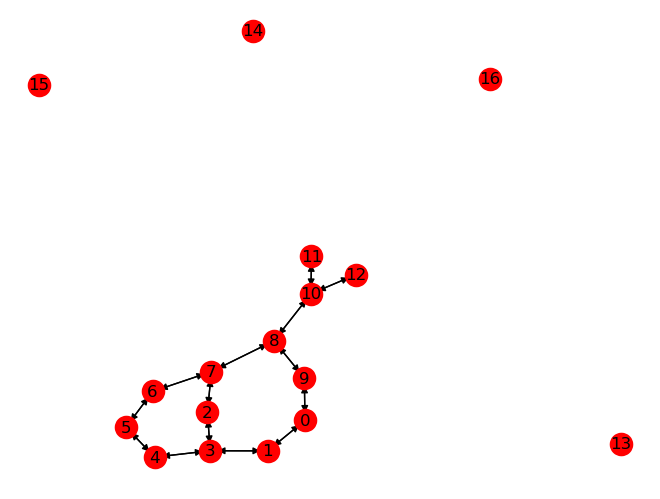

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  4.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  18.0
Distance to the second graph, level = 4:  104.0
add  0 4


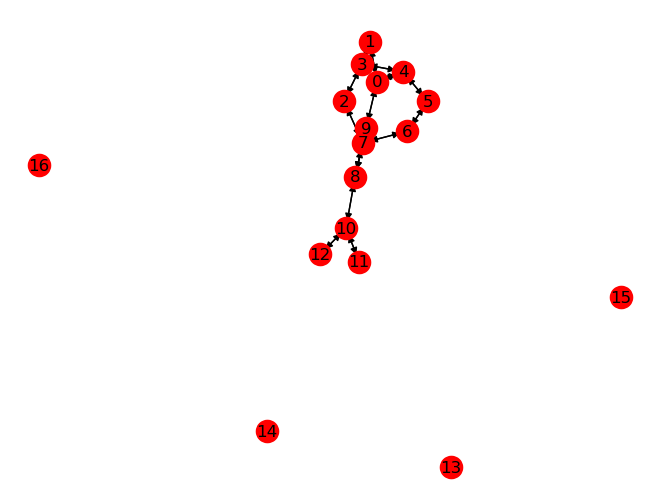

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  28.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  50.0
Distance to the second graph, level = 4:  86.0
add  7 4


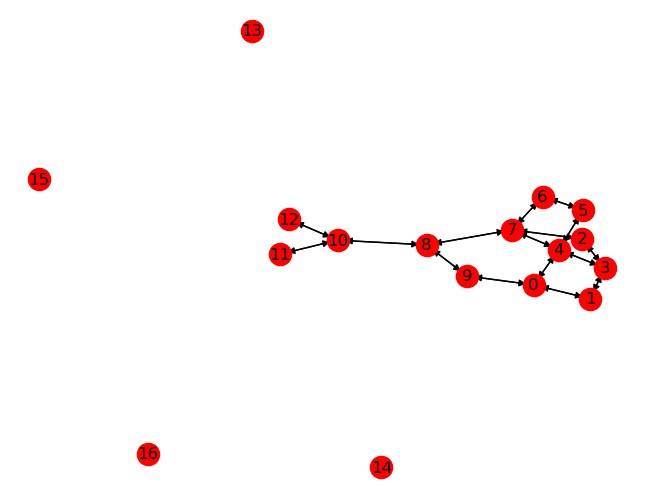

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  44.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  124.0
Distance to the second graph, level = 4:  156.0
remove  3 4


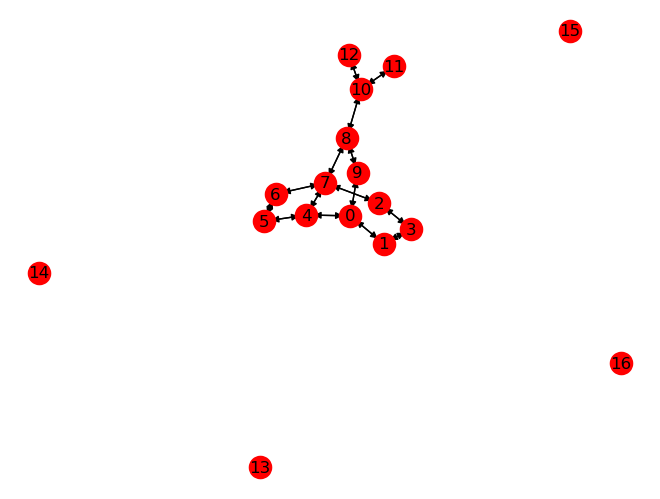

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  14.0
Distance to the second graph, level = 3:  38.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  60.0
Distance to the second graph, level = 4:  116.0
add  7 5


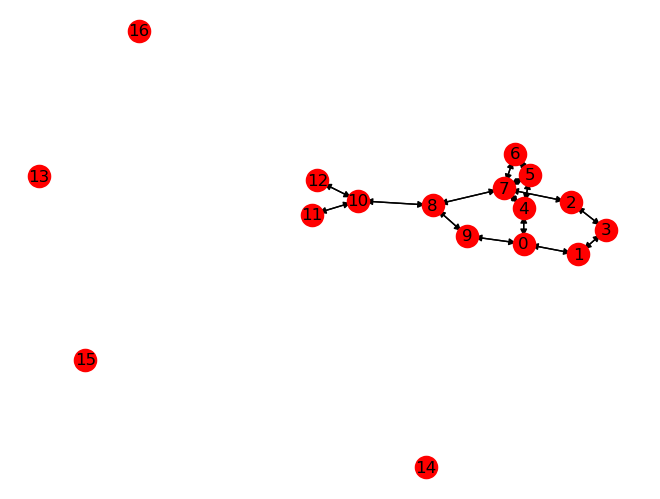

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  30.0
Distance to the second graph, level = 3:  48.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  136.0
Distance to the second graph, level = 4:  176.0
remove  4 5


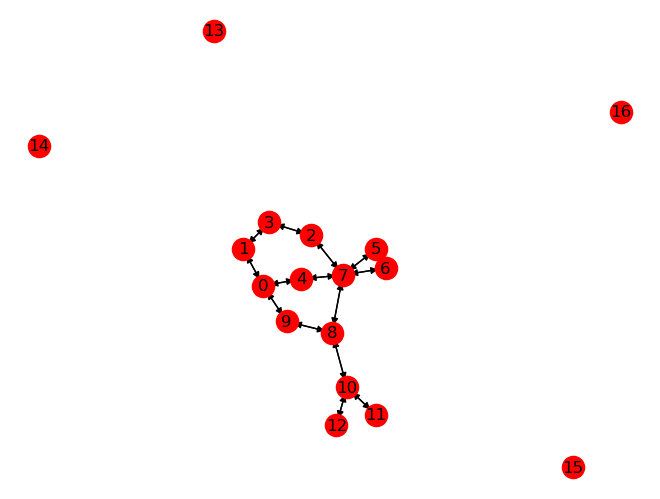

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  12.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  22.0
Distance to the second graph, level = 3:  50.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  94.0
Distance to the second graph, level = 4:  168.0
remove  6 7


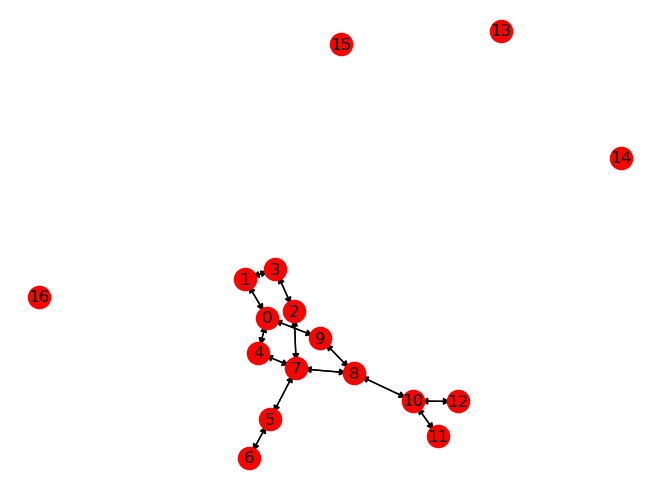

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  12.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  16.0
Distance to the second graph, level = 3:  46.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  60.0
Distance to the second graph, level = 4:  144.0
add  6 8


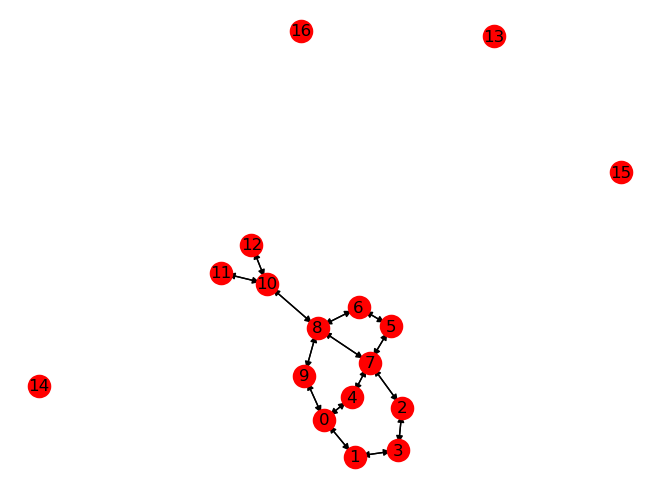

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  12.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  20.0
Distance to the second graph, level = 3:  48.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  86.0
Distance to the second graph, level = 4:  160.0
remove  7 8


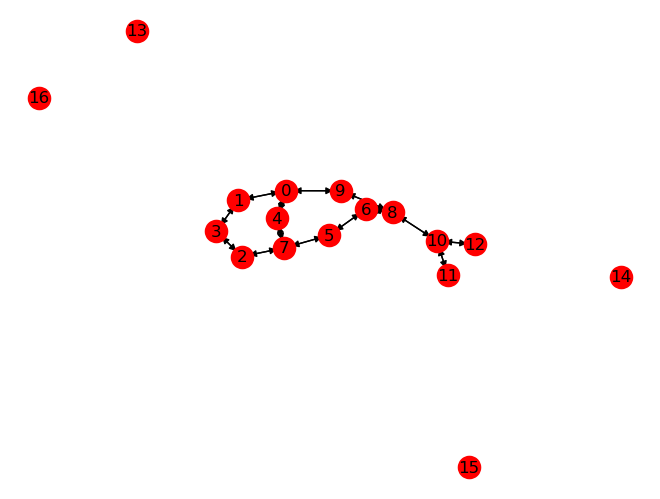

Distance between original graphs:  10.0
Distance to the first graph:  0.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  8.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  32.0
Distance to the second graph, level = 4:  106.0
add  2 10


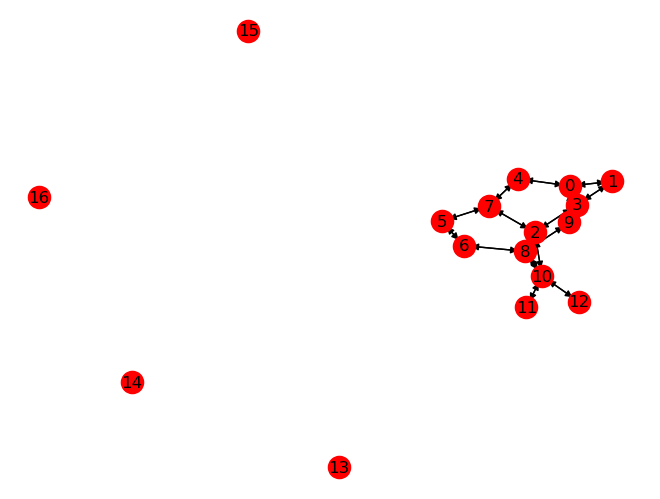

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  16.0
Distance to the second graph, level = 3:  36.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  64.0
Distance to the second graph, level = 4:  104.0
remove  0 9


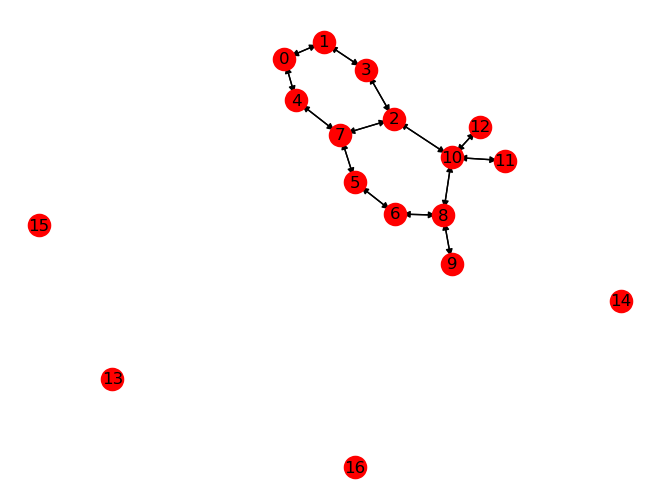

Distance between original graphs:  10.0
Distance to the first graph:  2.0
Distance to the second graph:  12.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  12.0
Distance to the second graph, level = 3:  44.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  44.0
Distance to the second graph, level = 4:  128.0
add  16 15


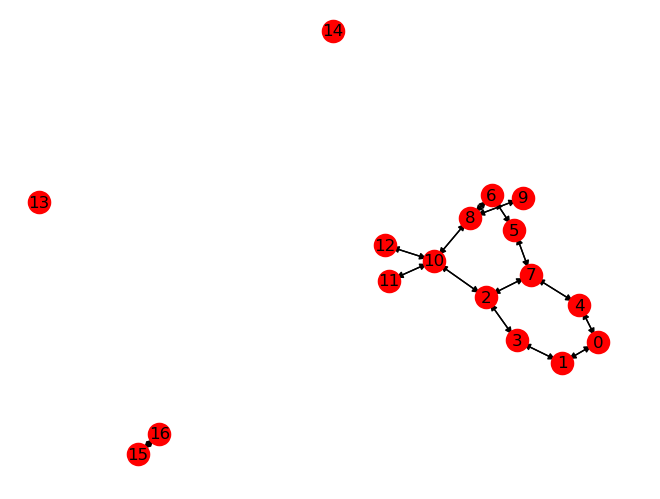

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  10.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  16.0
Distance to the second graph, level = 3:  40.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  50.0
Distance to the second graph, level = 4:  122.0
add  15 14


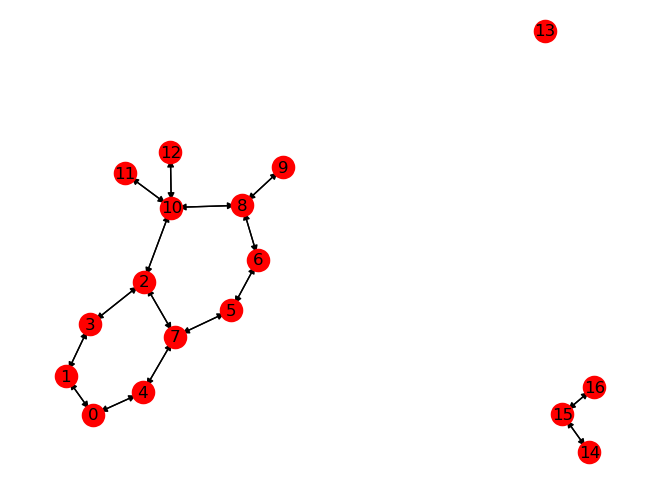

Distance between original graphs:  10.0
Distance to the first graph:  4.0
Distance to the second graph:  8.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  20.0
Distance to the second graph, level = 3:  34.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  62.0
Distance to the second graph, level = 4:  110.0
add  15 13


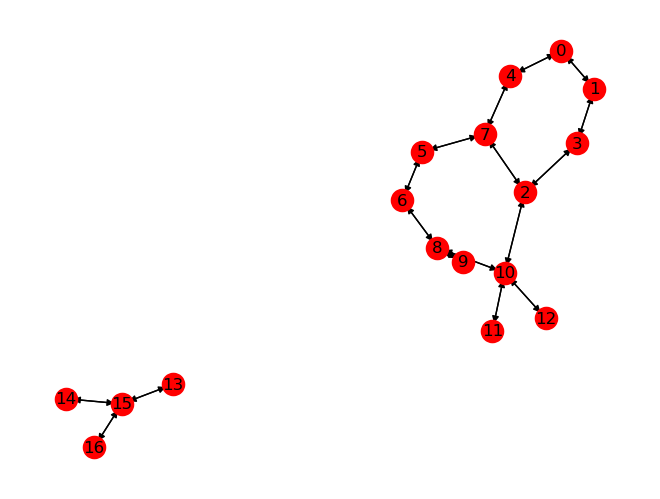

Distance between original graphs:  10.0
Distance to the first graph:  6.0
Distance to the second graph:  6.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  28.0
Distance to the second graph, level = 3:  26.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  78.0
Distance to the second graph, level = 4:  92.0
add  13 11


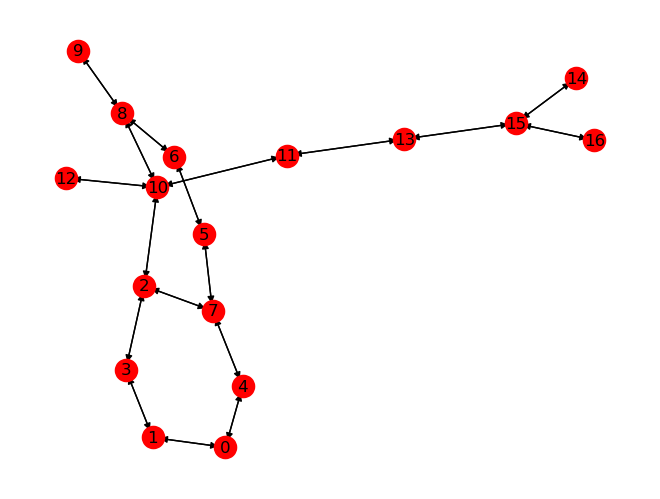

Distance between original graphs:  10.0
Distance to the first graph:  8.0
Distance to the second graph:  4.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  30.0
Distance to the second graph, level = 3:  18.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  84.0
Distance to the second graph, level = 4:  64.0
add  9 16


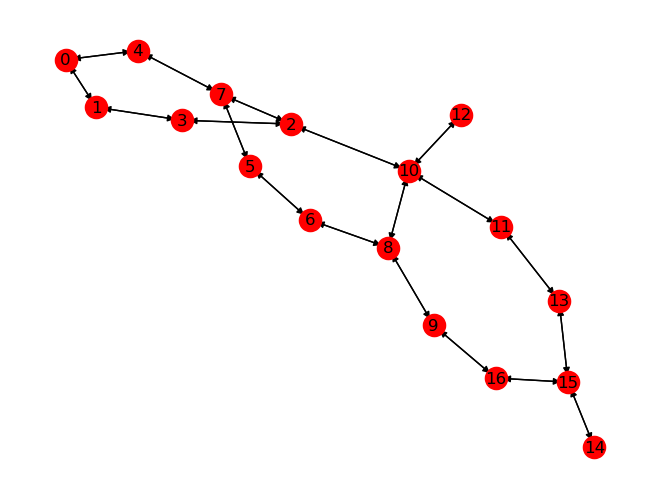

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  38.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  112.0
Distance to the second graph, level = 4:  48.0
add  13 12


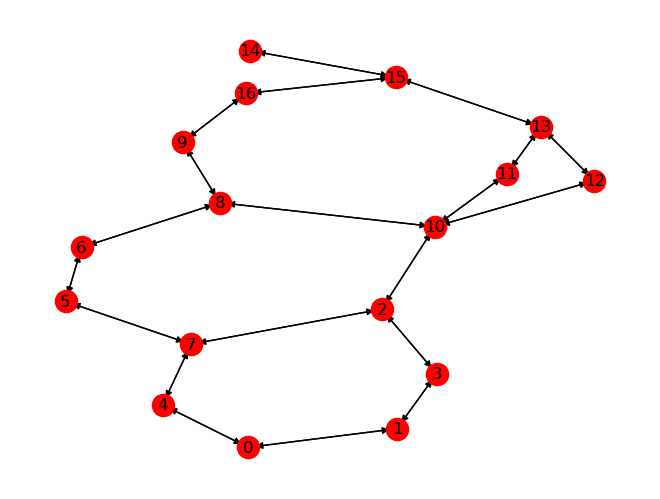

Distance between original graphs:  10.0
Distance to the first graph:  12.0
Distance to the second graph:  2.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  48.0
Distance to the second graph, level = 3:  12.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  152.0
Distance to the second graph, level = 4:  52.0
remove  10 12


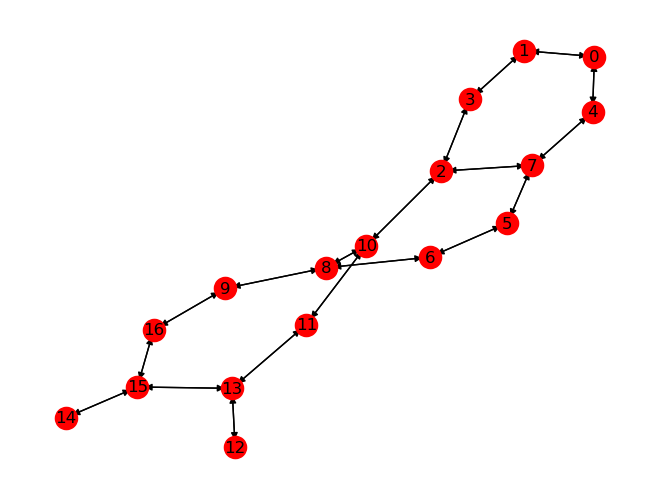

Distance between original graphs:  10.0
Distance to the first graph:  10.0
Distance to the second graph:  0.0
**********
Distance between original graphs, level = 3:  36.0
Distance to the first graph, level = 3:  36.0
Distance to the second graph, level = 3:  2.0
**********
Distance between original graphs, level = 4:  102.0
Distance to the first graph, level = 4:  102.0
Distance to the second graph, level = 4:  16.0


In [495]:
node_al = i[0]
edge_al = i[1]
nx.draw(G34,  with_labels=True)
#     fig.tight_layout()
plt.show()
follow_edit_path(G34, node_al, edge_al, d1 , d2)